In [7]:
!pip install dtaidistance
!pip install tslearn

In [8]:
import random
from copy import deepcopy

import numpy as np
import plotly.graph_objects as go
from dtaidistance import dtw
from plotly.subplots import make_subplots
from scipy import interpolate


import numpy
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from keras.optimizers import Adam, Nadam, Adamax
import pandas as pd
from pandas import DataFrame
from pandas import concat
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler

In [9]:
country=['Canada','Denmark','France','Germany','Netherlands','United Kingdom','Italy','Israel','Australia','Luxembourg','Japan','Portugal','Croatia','Finland','Ireland','Iceland','Norway','New Zealand','Brazil','Mexico','United States','India','Russia','Poland','Sweden']

# **CLUSTERING BY 3 FEATURES**

In [10]:
def tag():
  if i == "United Kingdom":
    return "UK"
  else:
    return i[:3].upper()

# fecha=datetime.today().strftime('%Y%m%d')
# total_start_time = time.time()

# path=("/home/org00004/LSTM/plots/"+fecha+"_knn")
# Path(path).mkdir(parents=True, exist_ok=True)

#SEED
seed = 7
numpy.random.seed(7)
tf.random.set_seed(123)


#LOADING DATASET
dataset_global = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')
dataset_global["Date"]= pd.to_datetime(dataset_global["Date"], format='%Y%m%d')

#Rules
c1={'N':3, 'F':1}
c2={'N':3, 'F':1}
c3={'N':2, 'F':1}
c4={'N':4, 'F':1}
c5={'N':2, 'F':1}
c6={'N':3, 'F':1}
c7={'N':2, 'F':1}
c8={'N':4, 'F':0}
e1={'N':2, 'F':1}
e2={'N':2, 'F':0}
h1={'N':2, 'F':1}
h2={'N':3, 'F':0}
h3={'N':2, 'F':0}



full_set = pd.DataFrame()
for i in country:
  dataset=dataset_global.loc[( (dataset_global.CountryName ==i) & (dataset_global.Date > "2020-01-01")& (dataset_global.Date < "2020-05-01")),['CountryName','CountryCode','Date','C1_School closing','C1_Flag','C2_Workplace closing','C2_Flag','C3_Cancel public events','C3_Flag','C4_Restrictions on gatherings','C4_Flag','C5_Close public transport','C5_Flag','C6_Stay at home requirements','C6_Flag','C7_Restrictions on internal movement','C7_Flag','C8_International travel controls','E1_Income support','E1_Flag','E2_Debt/contract relief','E3_Fiscal measures','E4_International support','H1_Public information campaigns','H1_Flag','H2_Testing policy','H3_Contact tracing','H4_Emergency investment in healthcare','H5_Investment in vaccines','M1_Wildcard','ConfirmedCases','ConfirmedDeaths']].set_index('Date')
  dataset.columns = ['CountryName','CountryCode','C1','C1_Flag','C2','C2_Flag','C3','C3_Flag','C4','C4_Flag','C5','C5_Flag','C6','C6_Flag','C7','C7_Flag','C8','E1','E1_Flag','E2','E3','E4','H1','H1_Flag','H2','H3','H4','H5','M1','ConfirmedCases','ConfirmedDeaths']

  #filling NaN due to uplead delay (Because data are updated on twice-weekly cycles, but not every country is updated in every cycle)
  dataset.fillna(method='ffill', inplace=True)

  #columns to look for missing values.
  dataset.dropna(subset=['ConfirmedDeaths'])

  dataset['C1_new']=round(100*((dataset['C1']-(0.5*(c1['F']-dataset['C1_Flag'])))/c1['N']),2)
  dataset.loc[(dataset['C1_new'] < 0), 'C1_new'] = 0
  dataset['C1_new']=dataset['C1_new'].fillna(0)

  dataset['C2_new']=round(100*((dataset['C2']-(0.5*(c2['F']-dataset['C2_Flag'])))/c2['N']),2)
  dataset.loc[(dataset['C2_new'] < 0), 'C2_new'] = 0
  dataset['C2_new']=dataset['C2_new'].fillna(0)

  dataset['C3_new']=round(100*((dataset['C3']-(0.5*(c3['F']-dataset['C3_Flag'])))/c3['N']),2)
  dataset.loc[(dataset['C3_new'] < 0), 'C3_new'] = 0
  dataset['C3_new']=dataset['C3_new'].fillna(0)

  dataset['C4_new']=round(100*((dataset['C4']-(0.5*(c4['F']-dataset['C4_Flag'])))/c4['N']),2)
  dataset.loc[(dataset['C4_new'] < 0), 'C4_new'] = 0
  dataset['C4_new']=dataset['C4_new'].fillna(0)

  dataset['C5_new']=round(100*((dataset['C5']-(0.5*(c5['F']-dataset['C5_Flag'])))/c5['N']),2)
  dataset.loc[(dataset['C5_new'] < 0), 'C5_new'] = 0
  dataset['C5_new']=dataset['C5_new'].fillna(0)

  dataset['C6_new']=round(100*((dataset['C6']-(0.5*(c6['F']-dataset['C6_Flag'])))/c6['N']),2)
  dataset.loc[(dataset['C6_new'] < 0), 'C6_new'] = 0
  dataset['C6_new']=dataset['C6_new'].fillna(0)

  dataset['C7_new']=round(100*((dataset['C7']-(0.5*(c7['F']-dataset['C7_Flag'])))/c7['N']),2)
  dataset.loc[(dataset['C7_new'] < 0), 'C7_new'] = 0
  dataset['C7_new']=dataset['C7_new'].fillna(0)

  dataset['C8_new']=round(100*((dataset['C8']-(0.5*(c8['F'])))/c8['N']),2)
  dataset.loc[(dataset['C8_new'] < 0), 'C8_new'] = 0
  dataset['C8_new']=dataset['C8_new'].fillna(0)

  dataset['E1_new']=round(100*((dataset['E1']-(0.5*(e1['F']-dataset['E1_Flag'])))/e1['N']),2)
  dataset.loc[(dataset['E1_new'] < 0), 'E1_new'] = 0
  dataset['E1_new']=dataset['E1_new'].fillna(0)

  dataset['E2_new']=round(100*((dataset['E2']-(0.5*(e2['F'])))/e2['N']),2)
  dataset.loc[(dataset['E2_new'] < 0), 'E2_new'] = 0
  dataset['E2_new']=dataset['E2_new'].fillna(0)

  dataset['H1_new']=round(100*((dataset['H1']-(0.5*(h1['F']-dataset['H1_Flag'])))/h1['N']),2)
  dataset.loc[(dataset['H1_new'] < 0), 'H1_new'] = 0
  dataset['H1_new']=dataset['H1_new'].fillna(0)

  dataset['H2_new']=round(100*((dataset['H2']-(0.5*(h2['F'])))/h2['N']),2)
  dataset.loc[(dataset['H2_new'] < 0), 'H2_new'] = 0
  dataset['H2_new']=dataset['H2_new'].fillna(0)

  dataset['H3_new']=round(100*((dataset['H3']-(0.5*(h3['F'])))/h3['N']),2)
  dataset.loc[(dataset['H3_new'] < 0), 'H3_new'] = 0
  dataset['H3_new']=dataset['H3_new'].fillna(0)

  dataset['politic']=dataset[['C1_new','C2_new','C3_new','C4_new','C5_new','C6_new','C7_new','C8_new']].mean(axis = 1)
  dataset['economic']=dataset[['E1_new','E2_new']].mean(axis = 1)
  dataset['health']=dataset[['H1_new','H2_new','H3_new']].mean(axis = 1)

  #creating death toll per day
  # dataset['Deaths_day']=dataset['ConfirmedDeaths'].diff()
  # dataset=dataset.drop(columns=['ConfirmedDeaths'])

  # dataset=dataset[['Deaths_day','politic','economic','health']]
  # dataset=dataset.dropna()

  features=['politic','economic','health']

  indexes_covid=dataset[features]
  indexes_covid.columns = ['politic_'+tag(),'economic_'+tag(),'health_'+tag()]

  full_set= pd.concat([full_set, indexes_covid], axis=1).dropna()

titles=['POLITIC FEATURES','ECONOMIC FEATURES','HEALTH FEATURES']

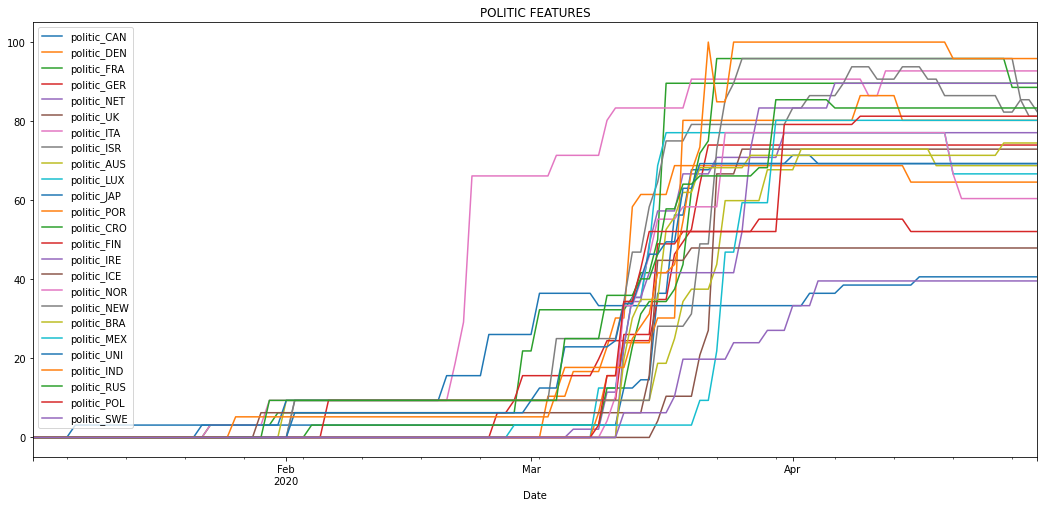

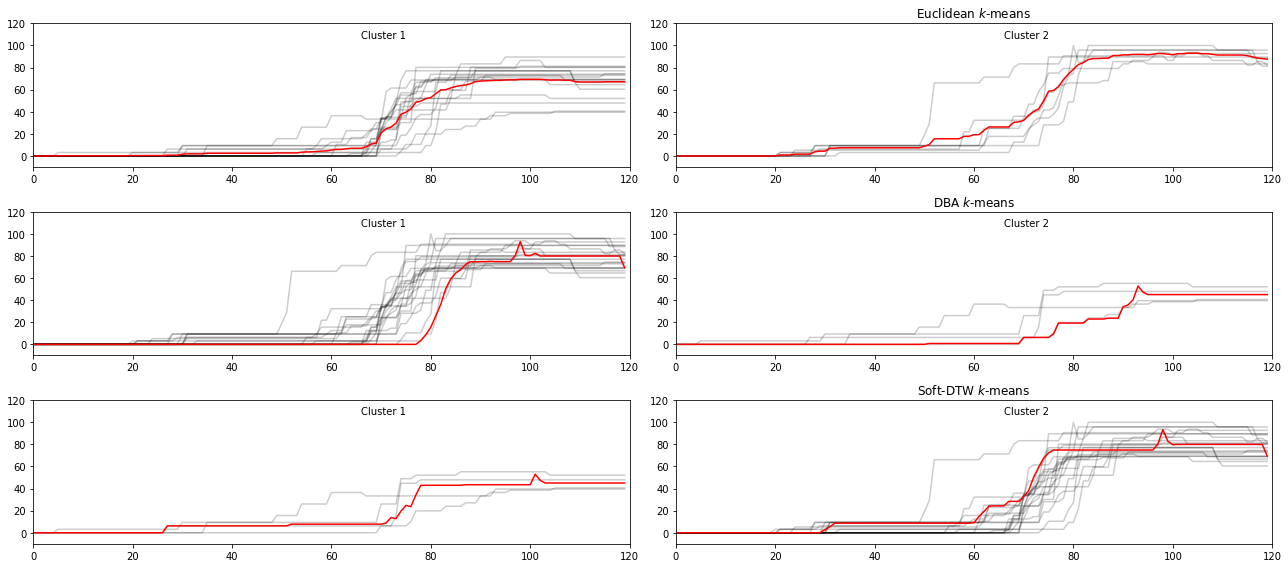

Euclidean k-means
The cluster 1 is composed by the features:
politic_CAN,politic_DEN,politic_GER,politic_NET,politic_UK'
 'politic_AUS,politic_LUX,politic_JAP,politic_POR,politic_FIN'
 'politic_IRE,politic_ICE,politic_NOR,politic_BRA,politic_MEX'
 'politic_UNI,politic_POL,politic_SWE
The cluster 2 is composed by the features:
politic_FRA,politic_ITA,politic_ISR,politic_CRO,politic_NEW'
 'politic_IND,politic_RUS
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
politic_CAN,politic_DEN,politic_FRA,politic_GER,politic_NET'
 'politic_UK,politic_ITA,politic_ISR,politic_AUS,politic_LUX'
 'politic_POR,politic_CRO,politic_IRE,politic_NOR,politic_NEW'
 'politic_BRA,politic_MEX,politic_UNI,politic_IND,politic_RUS'
 'politic_POL
The cluster 2 is composed by the features:
politic_JAP,politic_FIN,politic_ICE,politic_SWE
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by t

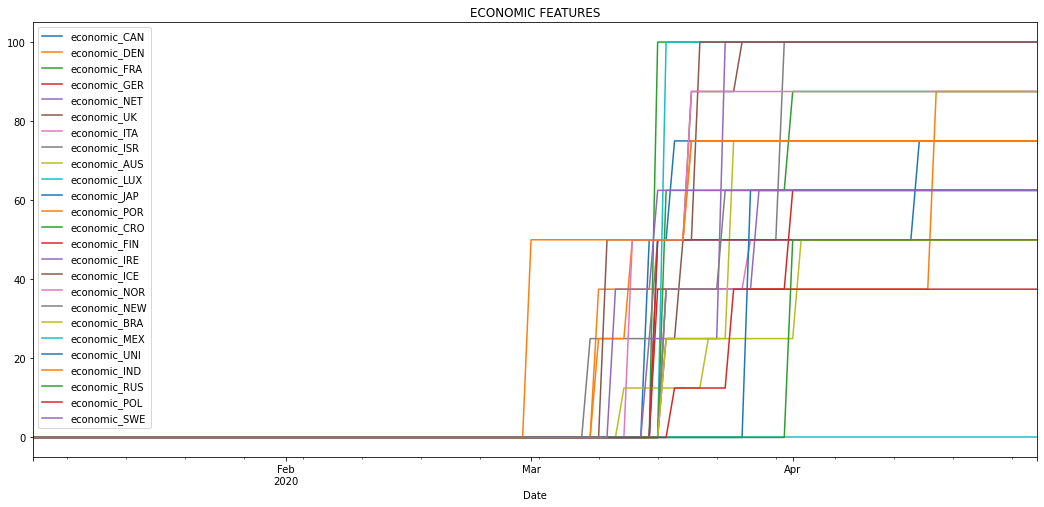

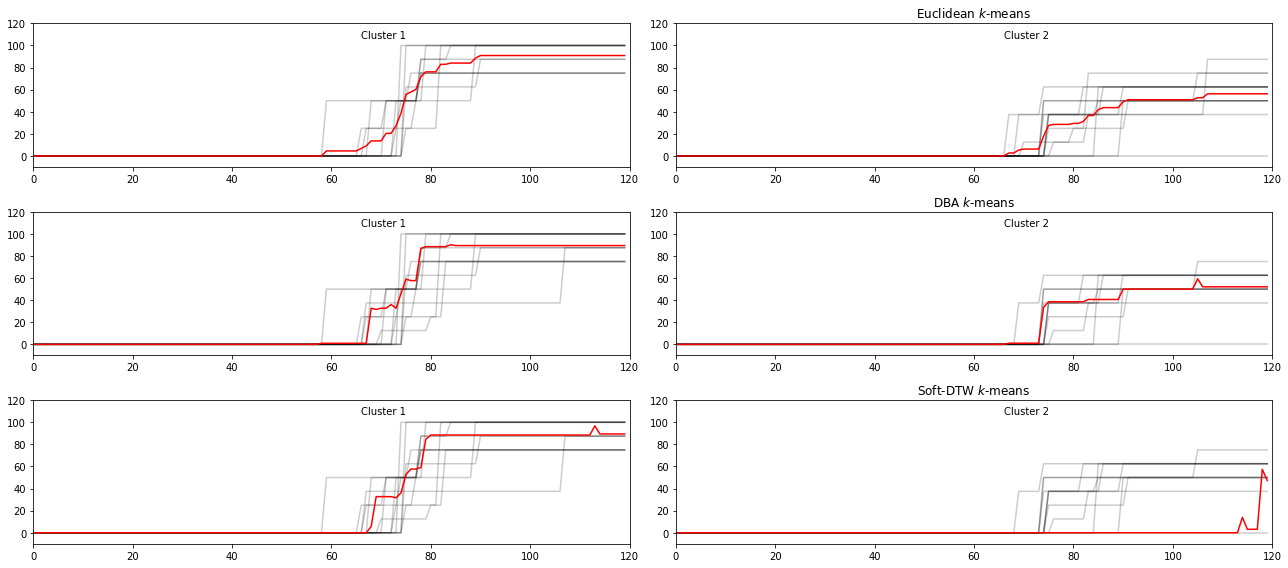

Euclidean k-means
The cluster 1 is composed by the features:
economic_CAN,economic_FRA,economic_UK,economic_ISR,economic_LUX'
 'economic_POR,economic_CRO,economic_IRE,economic_ICE'
 'economic_NOR,economic_IND
The cluster 2 is composed by the features:
economic_DEN,economic_GER,economic_NET,economic_ITA'
 'economic_AUS,economic_JAP,economic_FIN,economic_NEW'
 'economic_BRA,economic_MEX,economic_UNI,economic_RUS'
 'economic_POL,economic_SWE
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
economic_CAN,economic_DEN,economic_FRA,economic_UK,economic_ISR'
 'economic_AUS,economic_LUX,economic_POR,economic_CRO'
 'economic_IRE,economic_ICE,economic_NOR,economic_IND
The cluster 2 is composed by the features:
economic_GER,economic_NET,economic_ITA,economic_JAP'
 'economic_FIN,economic_NEW,economic_BRA,economic_MEX'
 'economic_UNI,economic_RUS,economic_POL,economic_SWE
********************************************
Sof

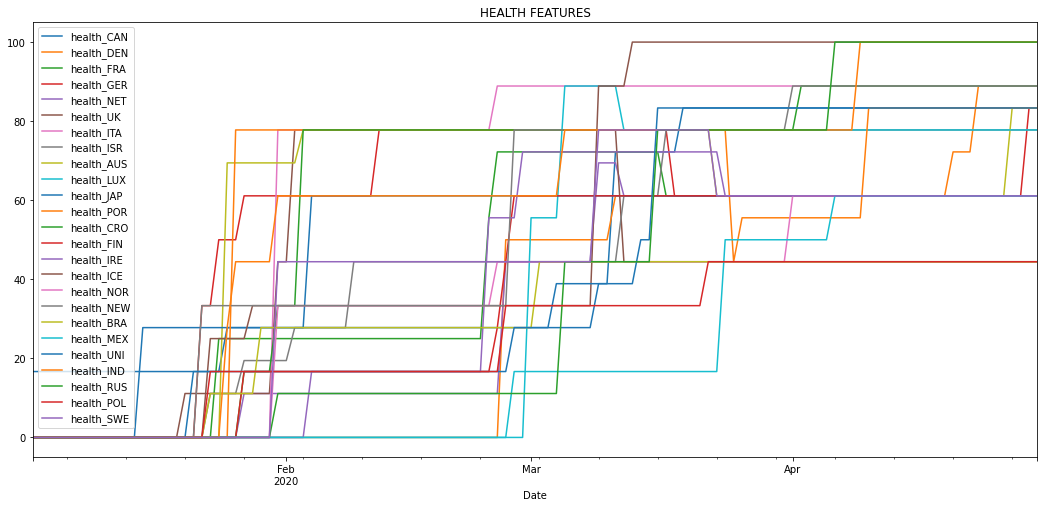

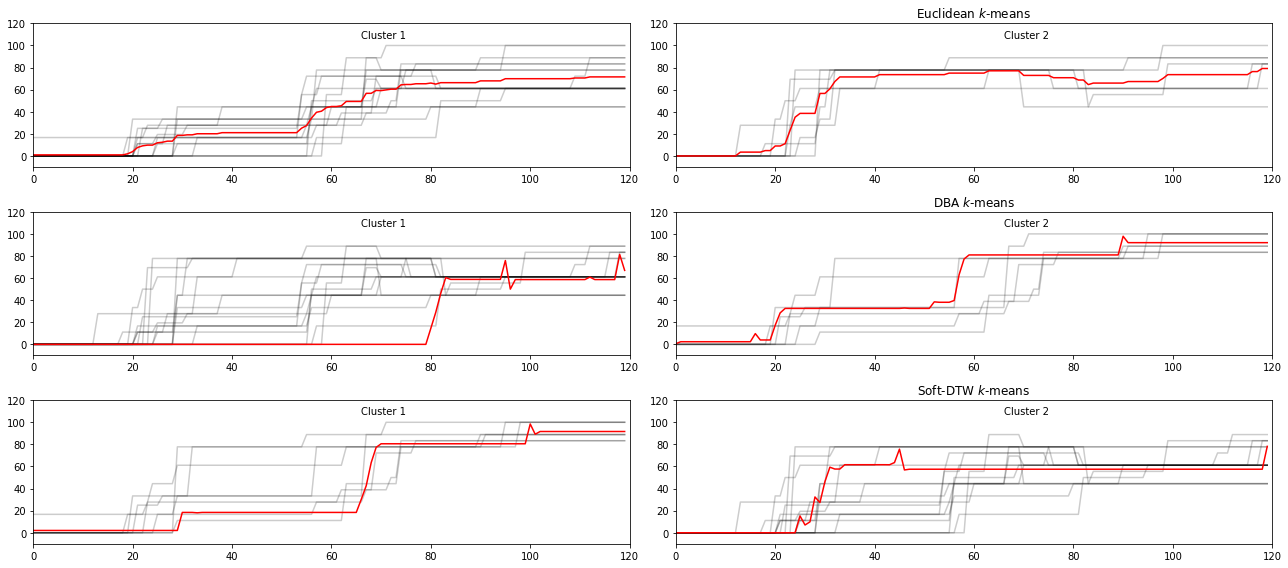

Euclidean k-means
The cluster 1 is composed by the features:
health_CAN,health_DEN,health_FRA,health_NET,health_ISR'
 'health_LUX,health_FIN,health_IRE,health_ICE,health_NOR'
 'health_NEW,health_BRA,health_MEX,health_UNI,health_RUS'
 'health_POL,health_SWE
The cluster 2 is composed by the features:
health_GER,health_UK,health_ITA,health_AUS,health_JAP'
 'health_POR,health_CRO,health_IND
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
health_DEN,health_FRA,health_GER,health_NET,health_UK'
 'health_ITA,health_ISR,health_AUS,health_LUX,health_JAP'
 'health_POR,health_FIN,health_IRE,health_NOR,health_BRA'
 'health_MEX,health_POL,health_SWE
The cluster 2 is composed by the features:
health_CAN,health_CRO,health_ICE,health_NEW,health_UNI'
 'health_IND,health_RUS
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
health_CAN,health_ITA,health_CRO,heal

In [11]:
cont=0
for x in features:
  nanai=full_set[[col for col in full_set if col.startswith(x)]]

  X_train=nanai.values
  X_train=X_train.T
  sz = X_train.shape[1]

  nanai.plot.line(figsize=(18,8), legend=True, title=titles[cont])
  cont += 1
  clusters=2

  # Euclidean k-means
  km = TimeSeriesKMeans(n_clusters=clusters, verbose=False, random_state=seed, n_jobs=-1)
  y_pred_0 = km.fit_predict(X_train)

  plt.figure(figsize=(18,8))
  for yi in range(clusters):
      plt.subplot(3, clusters, yi + 1)
      for xx in X_train[y_pred_0 == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
      plt.plot(km.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(-10, 120)
      plt.text(0.55, 0.9,'Cluster %d' % (yi + 1),
              transform=plt.gca().transAxes)
      if yi == 1:
          plt.title("Euclidean $k$-means")

  # DBA-k-means
  dba_km = TimeSeriesKMeans(n_clusters=clusters, n_init=2, metric="dtw",  verbose=False, max_iter_barycenter=10, random_state=seed)
  y_pred_1 = dba_km.fit_predict(X_train)

  for yi in range(clusters):
      plt.subplot(3, clusters, ((clusters*1)+1) + yi)
      for xx in X_train[y_pred_1 == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
      plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(-10, 120)
      plt.text(0.55, 0.9,'Cluster %d' % (yi + 1),
              transform=plt.gca().transAxes)
      if yi == 1:
          plt.title("DBA $k$-means")

  # Soft-DTW-k-meansy
  sdtw_km = TimeSeriesKMeans(n_clusters=clusters,  metric="softdtw", metric_params={"gamma": .01},  verbose=False, random_state=seed)
  y_pred_2 = sdtw_km.fit_predict(X_train)

  for yi in range(clusters):
      plt.subplot(3, clusters, ((clusters*2)+1) + yi)
      for xx in X_train[y_pred_2 == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
      plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(-10, 120)
      plt.text(0.55, 0.90,'Cluster %d' % (yi + 1),
              transform=plt.gca().transAxes)
      if yi == 1:
          plt.title("Soft-DTW $k$-means")

  plt.tight_layout()
  plt.show()
  # plt.savefig(path+"/plot")
  plt.clf()
  plt.close()

  # file1.write("Euclidean k-means\n")
  print("Euclidean k-means")
  for x in range(clusters):
    print("The cluster %i is composed by the features:" % (x+1))
    # file1.write("The cluster %i is composed by the features:\n" % (x+1))
    print(str(nanai.columns.where(y_pred_0 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))
    # file1.write(str(nanai.columns.where(y_pred_0 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", "")+"\n")
  print("********************************************")
  # file1.write("\nDBA k-means\n")
  print("Dynamic Time Warping Barycenter Averaging")
  for x in range(clusters):
    print("The cluster %i is composed by the features:" % (x+1))
    # file1.write("The cluster %i is composed by the features:\n" % (x+1))
    print(str(nanai.columns.where(y_pred_1 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))
    # file1.write(str(nanai.columns.where(y_pred_1 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", "")+"\n")
  print("********************************************")
  # file1.write("\nSoft-DTW k-means\n")
  print("Soft-Dynamic Time Warping")
  for x in range(clusters):
    print("The cluster %i is composed by the features:" % (x+1))
    # file1.write("The cluster %i is composed by the features:\n" % (x+1))
    print(str(nanai.columns.where(y_pred_2 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))
    # file1.write(str(nanai.columns.where(y_pred_2 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))

#barycenter in red

# **CLUSTERING BY 13 FEATURES**

In [12]:

def tag():
  if i == "United Kingdom":
    return "UK"
  else:
    return i[:3].upper()

# fecha=datetime.today().strftime('%Y%m%d')
# total_start_time = time.time()

# path=("/home/org00004/LSTM/plots/"+fecha+"_knn")
# Path(path).mkdir(parents=True, exist_ok=True)

#SEED
seed = 7
numpy.random.seed(7)
tf.random.set_seed(123)

#LOADING DATASET
dataset_global = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')
dataset_global["Date"]= pd.to_datetime(dataset_global["Date"], format='%Y%m%d')


full_set = pd.DataFrame()
for i in country:
	dataset=dataset_global.loc[( (dataset_global.CountryName ==i) & (dataset_global.Date > "2020-01-01")& (dataset_global.Date < "2020-05-01")),['CountryName','CountryCode','Date','C1_School closing','C1_Flag','C2_Workplace closing','C2_Flag','C3_Cancel public events','C3_Flag','C4_Restrictions on gatherings','C4_Flag','C5_Close public transport','C5_Flag','C6_Stay at home requirements','C6_Flag','C7_Restrictions on internal movement','C7_Flag','C8_International travel controls','E1_Income support','E1_Flag','E2_Debt/contract relief','E3_Fiscal measures','E4_International support','H1_Public information campaigns','H1_Flag','H2_Testing policy','H3_Contact tracing','H4_Emergency investment in healthcare','H5_Investment in vaccines','M1_Wildcard','ConfirmedCases','ConfirmedDeaths']].set_index('Date')
	dataset.columns = ['CountryName','CountryCode','C1','C1_Flag','C2','C2_Flag','C3','C3_Flag','C4','C4_Flag','C5','C5_Flag','C6','C6_Flag','C7','C7_Flag','C8','E1','E1_Flag','E2','E3','E4','H1','H1_Flag','H2','H3','H4','H5','M1','ConfirmedCases','ConfirmedDeaths']
	
	#filling NaN due to uplead delay (Because data are updated on twice-weekly cycles, but not every country is updated in every cycle)
	dataset.fillna(method='ffill', inplace=True)

	#columns to look for missing values.
	dataset.dropna(subset=['ConfirmedDeaths'])

	dataset['C1_new']=round(100*((dataset['C1']-(0.5*(c1['F']-dataset['C1_Flag'])))/c1['N']),2)
	dataset.loc[(dataset['C1_new'] < 0), 'C1_new'] = 0
	dataset['C1_new']=dataset['C1_new'].fillna(0)

	dataset['C2_new']=round(100*((dataset['C2']-(0.5*(c2['F']-dataset['C2_Flag'])))/c2['N']),2)
	dataset.loc[(dataset['C2_new'] < 0), 'C2_new'] = 0
	dataset['C2_new']=dataset['C2_new'].fillna(0)

	dataset['C3_new']=round(100*((dataset['C3']-(0.5*(c3['F']-dataset['C3_Flag'])))/c3['N']),2)
	dataset.loc[(dataset['C3_new'] < 0), 'C3_new'] = 0
	dataset['C3_new']=dataset['C3_new'].fillna(0)

	dataset['C4_new']=round(100*((dataset['C4']-(0.5*(c4['F']-dataset['C4_Flag'])))/c4['N']),2)
	dataset.loc[(dataset['C4_new'] < 0), 'C4_new'] = 0
	dataset['C4_new']=dataset['C4_new'].fillna(0)

	dataset['C5_new']=round(100*((dataset['C5']-(0.5*(c5['F']-dataset['C5_Flag'])))/c5['N']),2)
	dataset.loc[(dataset['C5_new'] < 0), 'C5_new'] = 0
	dataset['C5_new']=dataset['C5_new'].fillna(0)

	dataset['C6_new']=round(100*((dataset['C6']-(0.5*(c6['F']-dataset['C6_Flag'])))/c6['N']),2)
	dataset.loc[(dataset['C6_new'] < 0), 'C6_new'] = 0
	dataset['C6_new']=dataset['C6_new'].fillna(0)

	dataset['C7_new']=round(100*((dataset['C7']-(0.5*(c7['F']-dataset['C7_Flag'])))/c7['N']),2)
	dataset.loc[(dataset['C7_new'] < 0), 'C7_new'] = 0
	dataset['C7_new']=dataset['C7_new'].fillna(0)

	dataset['C8_new']=round(100*((dataset['C8']-(0.5*(c8['F'])))/c8['N']),2)
	dataset.loc[(dataset['C8_new'] < 0), 'C8_new'] = 0
	dataset['C8_new']=dataset['C8_new'].fillna(0)

	dataset['E1_new']=round(100*((dataset['E1']-(0.5*(e1['F']-dataset['E1_Flag'])))/e1['N']),2)
	dataset.loc[(dataset['E1_new'] < 0), 'E1_new'] = 0
	dataset['E1_new']=dataset['E1_new'].fillna(0)

	dataset['E2_new']=round(100*((dataset['E2']-(0.5*(e2['F'])))/e2['N']),2)
	dataset.loc[(dataset['E2_new'] < 0), 'E2_new'] = 0
	dataset['E2_new']=dataset['E2_new'].fillna(0)

	dataset['H1_new']=round(100*((dataset['H1']-(0.5*(h1['F']-dataset['H1_Flag'])))/h1['N']),2)
	dataset.loc[(dataset['H1_new'] < 0), 'H1_new'] = 0
	dataset['H1_new']=dataset['H1_new'].fillna(0)

	dataset['H2_new']=round(100*((dataset['H2']-(0.5*(h2['F'])))/h2['N']),2)
	dataset.loc[(dataset['H2_new'] < 0), 'H2_new'] = 0
	dataset['H2_new']=dataset['H2_new'].fillna(0)

	dataset['H3_new']=round(100*((dataset['H3']-(0.5*(h3['F'])))/h3['N']),2)
	dataset.loc[(dataset['H3_new'] < 0), 'H3_new'] = 0
	dataset['H3_new']=dataset['H3_new'].fillna(0)

	#creating death toll per day
	# dataset['Deaths_day']=dataset['ConfirmedDeaths'].diff()
	# dataset=dataset.drop(columns=['ConfirmedDeaths'])
	
	# dataset=dataset[['Deaths_day','C1_new','C2_new','C3_new','C4_new','C5_new','C6_new','C7_new','C8_new','E1_new','E2_new','H1_new','H2_new','H3_new']]
	# dataset=dataset.dropna()
	
	features=['C1_new','C2_new','C3_new','C4_new','C5_new','C6_new','C7_new','C8_new','E1_new','E2_new','H1_new','H2_new','H3_new']

	indexes_covid=dataset[features]
	indexes_covid.columns = ['C1_'+tag(),'C2_'+tag(),'C3_'+tag(),'C4_'+tag(),'C5_'+tag(),'C6_'+tag(),'C7_'+tag(),'C8_'+tag(),'E1_'+tag(),'E2_'+tag(),'H1_'+tag(),'H2_'+tag(),'H3_'+tag()]
	
	full_set= pd.concat([full_set, indexes_covid], axis=1).dropna()
	
# X_train=full_set.values
# X_train=X_train.T
# sz = X_train.shape[1]

# full_set.plot.line(figsize=(18,8), legend=False)

titles=['School closing','Workplace closing','Cancel public events','Restrictions on gathering size','Close public transport','Stay at home requirements','Restrictions on internal movement','Restrictions on international travel','income support','debt/contract relief for households','Public information campaign','testing policy','contact tracing']

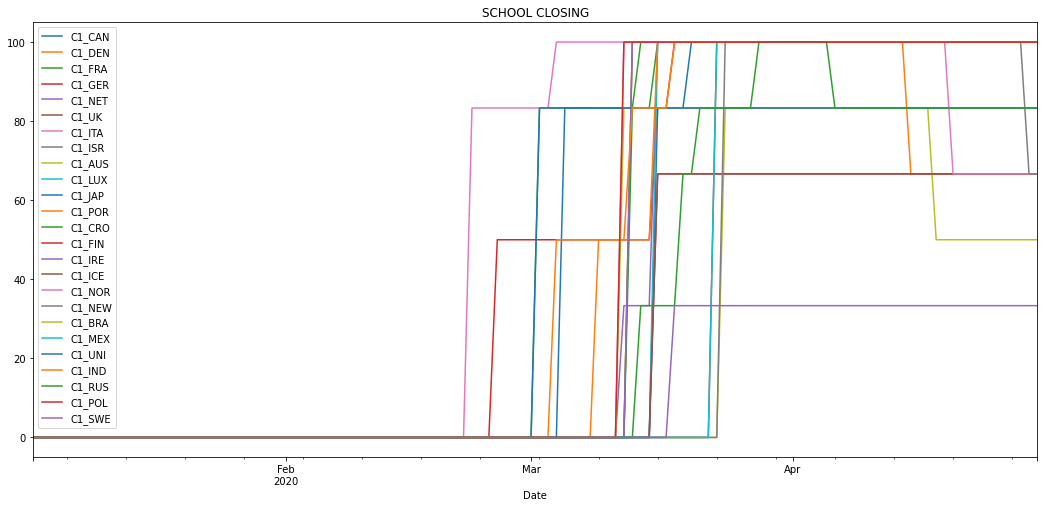

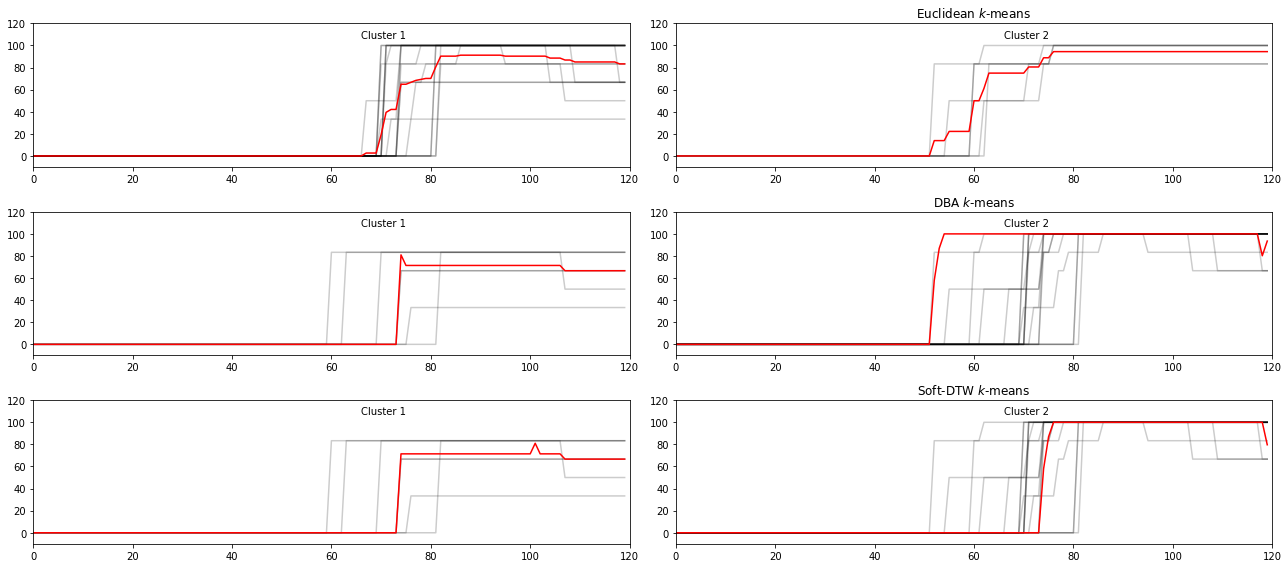

Euclidean k-means
The cluster 1 is composed by the features:
C1_CAN,C1_DEN,C1_NET,C1_UK,C1_ISR,C1_AUS,C1_LUX,C1_POR'
 'C1_CRO,C1_FIN,C1_IRE,C1_ICE,C1_NOR,C1_NEW,C1_BRA,C1_MEX'
 'C1_RUS,C1_POL,C1_SWE
The cluster 2 is composed by the features:
C1_FRA,C1_GER,C1_ITA,C1_JAP,C1_UNI,C1_IND
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C1_AUS,C1_JAP,C1_FIN,C1_ICE,C1_BRA,C1_UNI,C1_SWE
The cluster 2 is composed by the features:
C1_CAN,C1_DEN,C1_FRA,C1_GER,C1_NET,C1_UK,C1_ITA,C1_ISR'
 'C1_LUX,C1_POR,C1_CRO,C1_IRE,C1_NOR,C1_NEW,C1_MEX,C1_IND'
 'C1_RUS,C1_POL
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C1_AUS,C1_JAP,C1_FIN,C1_ICE,C1_BRA,C1_UNI,C1_SWE
The cluster 2 is composed by the features:
C1_CAN,C1_DEN,C1_FRA,C1_GER,C1_NET,C1_UK,C1_ITA,C1_ISR'
 'C1_LUX,C1_POR,C1_CRO,C1_IRE,C1_NOR,C1_NEW,C1_MEX,C1_IND'
 'C1_RUS,C1_POL


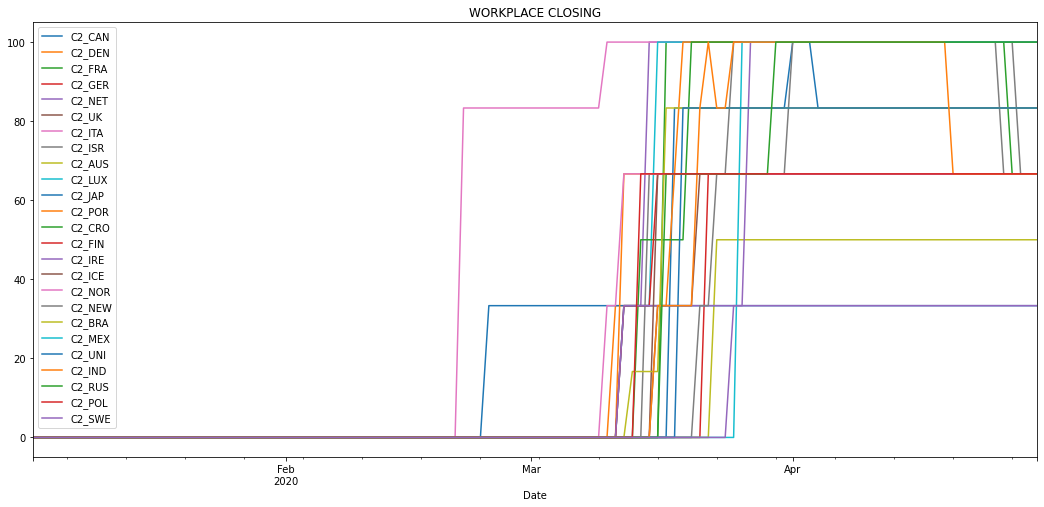

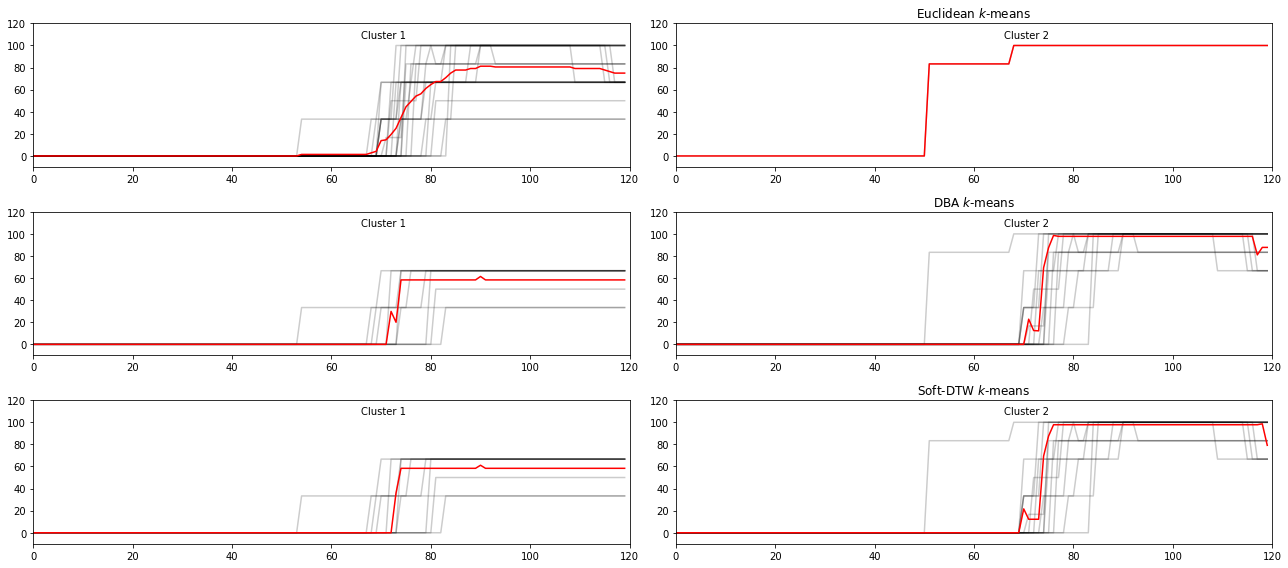

Euclidean k-means
The cluster 1 is composed by the features:
C2_CAN,C2_DEN,C2_FRA,C2_GER,C2_NET,C2_UK,C2_ISR,C2_AUS'
 'C2_LUX,C2_JAP,C2_POR,C2_CRO,C2_FIN,C2_IRE,C2_ICE,C2_NOR'
 'C2_NEW,C2_BRA,C2_MEX,C2_UNI,C2_IND,C2_RUS,C2_POL,C2_SWE
The cluster 2 is composed by the features:
C2_ITA
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C2_DEN,C2_GER,C2_UK,C2_AUS,C2_JAP,C2_FIN,C2_ICE,C2_NOR'
 'C2_POL,C2_SWE
The cluster 2 is composed by the features:
C2_CAN,C2_FRA,C2_NET,C2_ITA,C2_ISR,C2_LUX,C2_POR,C2_CRO'
 'C2_IRE,C2_NEW,C2_BRA,C2_MEX,C2_UNI,C2_IND,C2_RUS
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C2_DEN,C2_GER,C2_UK,C2_AUS,C2_JAP,C2_FIN,C2_ICE,C2_NOR'
 'C2_POL,C2_SWE
The cluster 2 is composed by the features:
C2_CAN,C2_FRA,C2_NET,C2_ITA,C2_ISR,C2_LUX,C2_POR,C2_CRO'
 'C2_IRE,C2_NEW,C2_BRA,C2_MEX,C2_UNI,C2_IND,C2_RUS


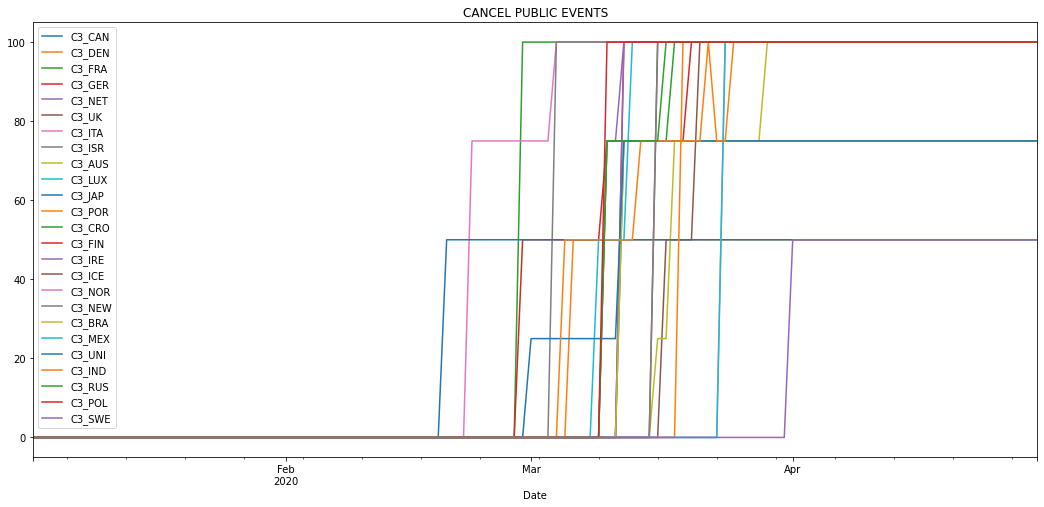

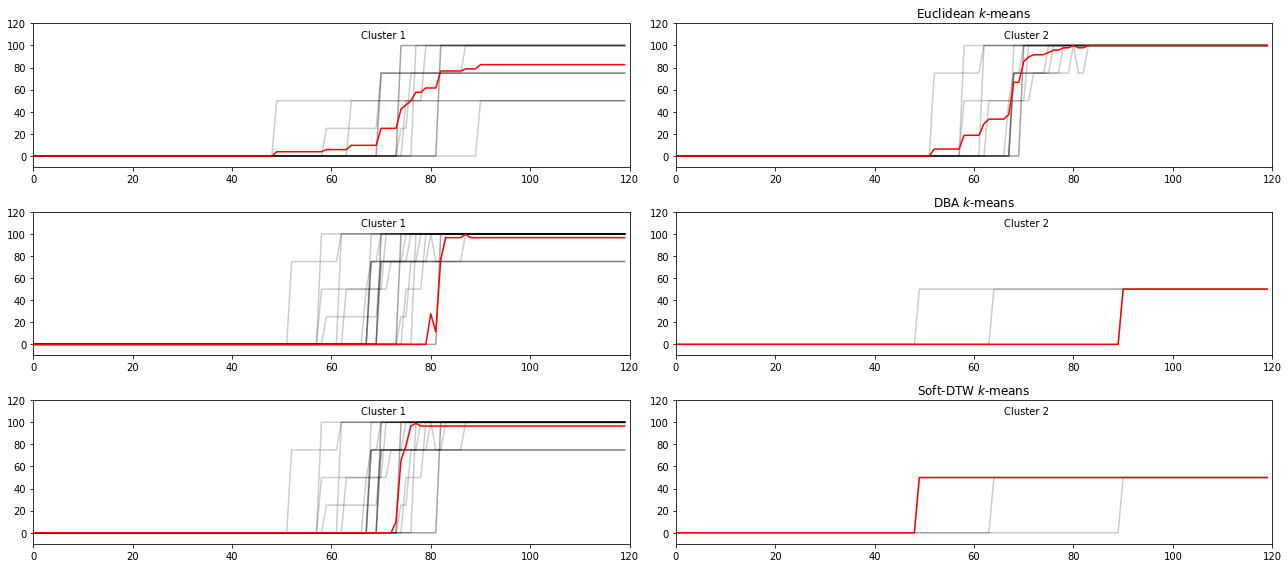

Euclidean k-means
The cluster 1 is composed by the features:
C3_CAN,C3_DEN,C3_UK,C3_AUS,C3_JAP,C3_POR,C3_ICE,C3_NOR'
 'C3_NEW,C3_BRA,C3_MEX,C3_UNI,C3_SWE
The cluster 2 is composed by the features:
C3_FRA,C3_GER,C3_NET,C3_ITA,C3_ISR,C3_LUX,C3_CRO,C3_FIN'
 'C3_IRE,C3_IND,C3_RUS,C3_POL
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C3_CAN,C3_FRA,C3_GER,C3_NET,C3_UK,C3_ITA,C3_ISR,C3_AUS'
 'C3_LUX,C3_POR,C3_CRO,C3_FIN,C3_IRE,C3_ICE,C3_NOR,C3_NEW'
 'C3_BRA,C3_MEX,C3_UNI,C3_IND,C3_RUS,C3_POL
The cluster 2 is composed by the features:
C3_DEN,C3_JAP,C3_SWE
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C3_CAN,C3_FRA,C3_GER,C3_NET,C3_UK,C3_ITA,C3_ISR,C3_AUS'
 'C3_LUX,C3_POR,C3_CRO,C3_FIN,C3_IRE,C3_ICE,C3_NOR,C3_NEW'
 'C3_BRA,C3_MEX,C3_UNI,C3_IND,C3_RUS,C3_POL
The cluster 2 is composed by the features:
C3_DEN,C3_JAP,C3_SWE


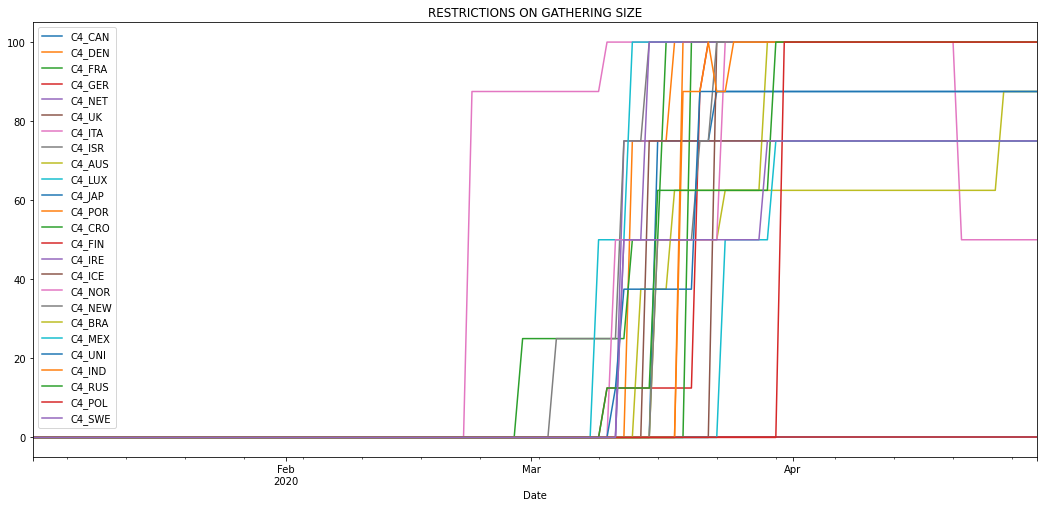

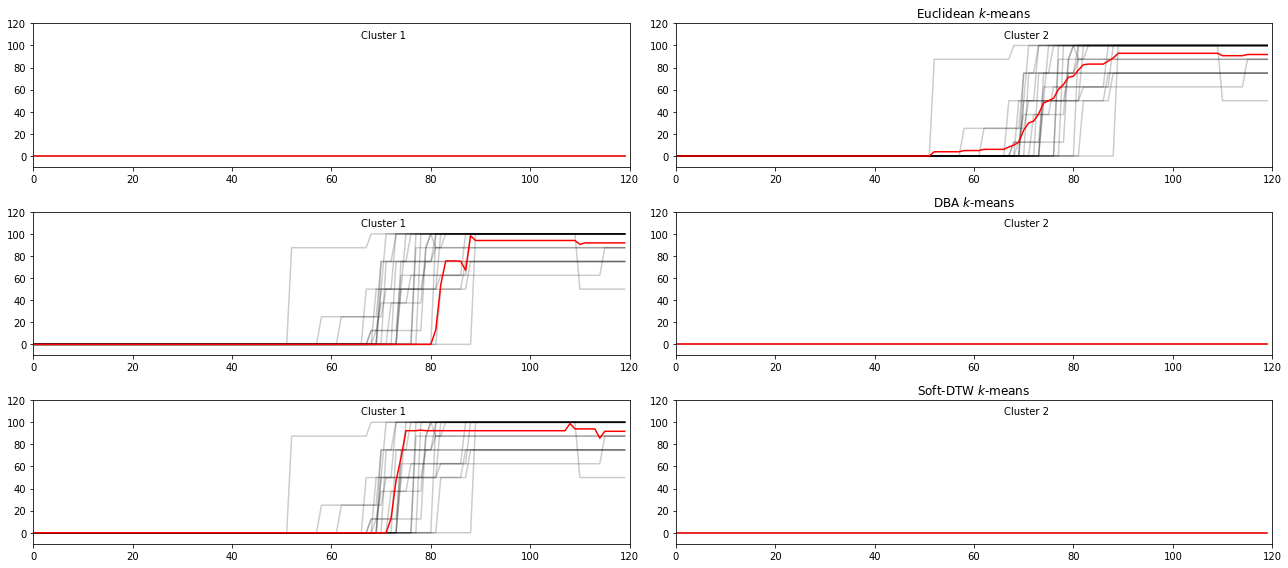

Euclidean k-means
The cluster 1 is composed by the features:
C4_JAP,C4_FIN
The cluster 2 is composed by the features:
C4_CAN,C4_DEN,C4_FRA,C4_GER,C4_NET,C4_UK,C4_ITA,C4_ISR'
 'C4_AUS,C4_LUX,C4_POR,C4_CRO,C4_IRE,C4_ICE,C4_NOR,C4_NEW'
 'C4_BRA,C4_MEX,C4_UNI,C4_IND,C4_RUS,C4_POL,C4_SWE
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C4_CAN,C4_DEN,C4_FRA,C4_GER,C4_NET,C4_UK,C4_ITA,C4_ISR'
 'C4_AUS,C4_LUX,C4_POR,C4_CRO,C4_IRE,C4_ICE,C4_NOR,C4_NEW'
 'C4_BRA,C4_MEX,C4_UNI,C4_IND,C4_RUS,C4_POL,C4_SWE
The cluster 2 is composed by the features:
C4_JAP,C4_FIN
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C4_CAN,C4_DEN,C4_FRA,C4_GER,C4_NET,C4_UK,C4_ITA,C4_ISR'
 'C4_AUS,C4_LUX,C4_POR,C4_CRO,C4_IRE,C4_ICE,C4_NOR,C4_NEW'
 'C4_BRA,C4_MEX,C4_UNI,C4_IND,C4_RUS,C4_POL,C4_SWE
The cluster 2 is composed by the features:
C4_JAP,C4_FIN


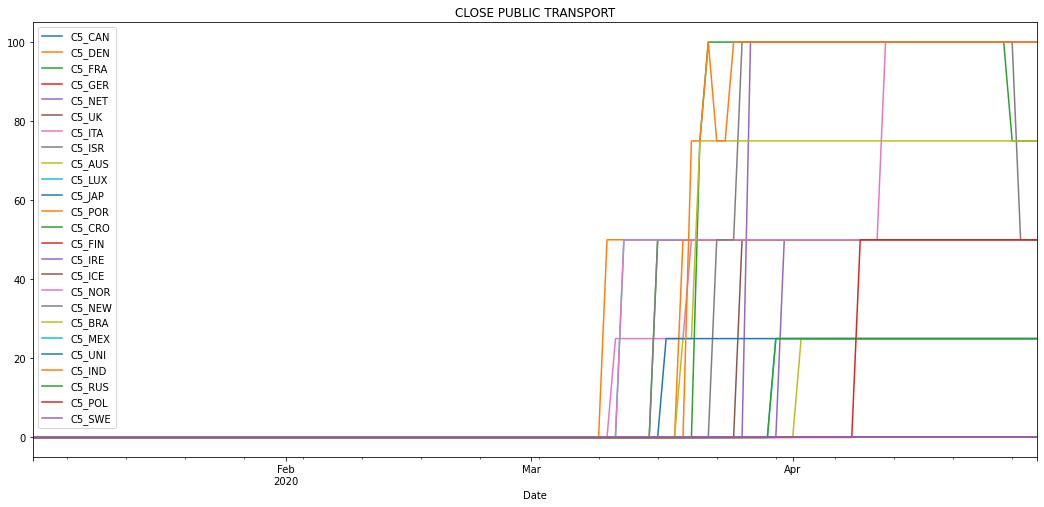

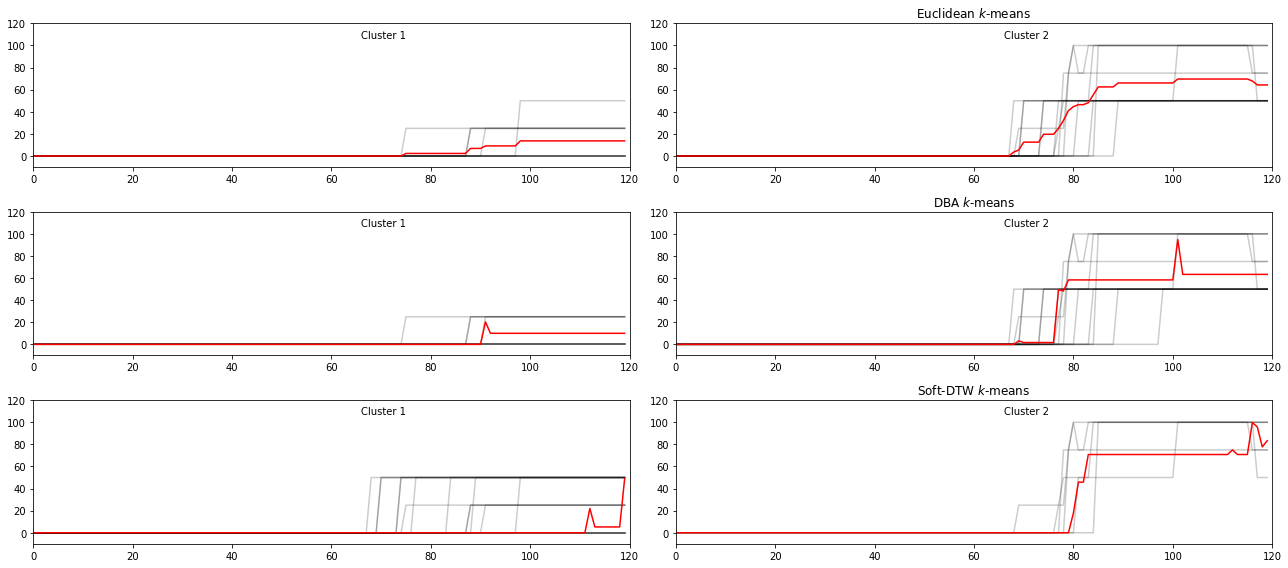

Euclidean k-means
The cluster 1 is composed by the features:
C5_CAN,C5_GER,C5_AUS,C5_JAP,C5_FIN,C5_ICE,C5_MEX,C5_UNI'
 'C5_RUS,C5_POL,C5_SWE
The cluster 2 is composed by the features:
C5_DEN,C5_FRA,C5_NET,C5_UK,C5_ITA,C5_ISR,C5_LUX,C5_POR'
 'C5_CRO,C5_IRE,C5_NOR,C5_NEW,C5_BRA,C5_IND
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C5_CAN,C5_GER,C5_AUS,C5_JAP,C5_FIN,C5_ICE,C5_MEX,C5_UNI'
 'C5_RUS,C5_SWE
The cluster 2 is composed by the features:
C5_DEN,C5_FRA,C5_NET,C5_UK,C5_ITA,C5_ISR,C5_LUX,C5_POR'
 'C5_CRO,C5_IRE,C5_NOR,C5_NEW,C5_BRA,C5_IND,C5_POL
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C5_CAN,C5_DEN,C5_FRA,C5_GER,C5_NET,C5_UK,C5_ISR,C5_AUS'
 'C5_LUX,C5_JAP,C5_POR,C5_FIN,C5_ICE,C5_NOR,C5_MEX,C5_UNI'
 'C5_RUS,C5_POL,C5_SWE
The cluster 2 is composed by the features:
C5_ITA,C5_CRO,C5_IRE,C5_NEW,C5_BRA,C5_IND


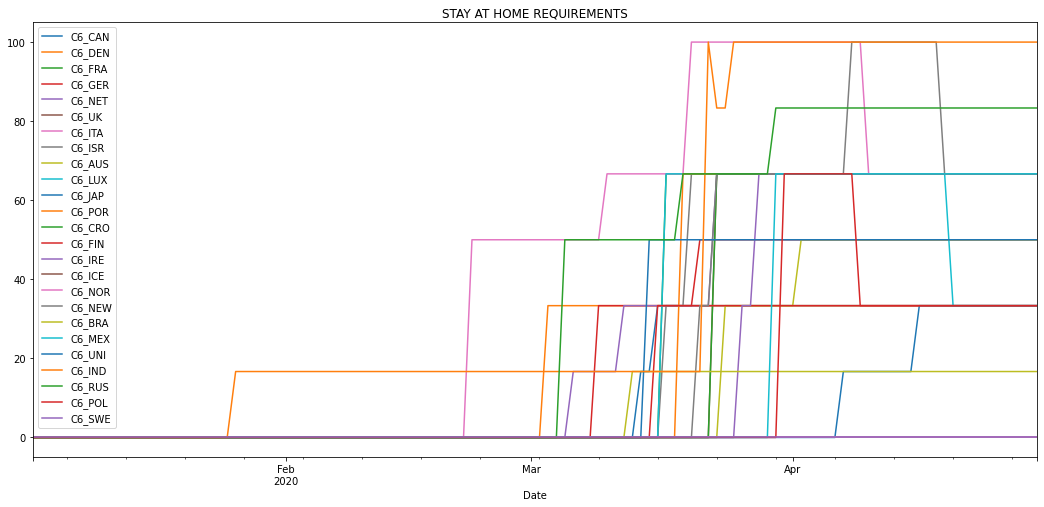

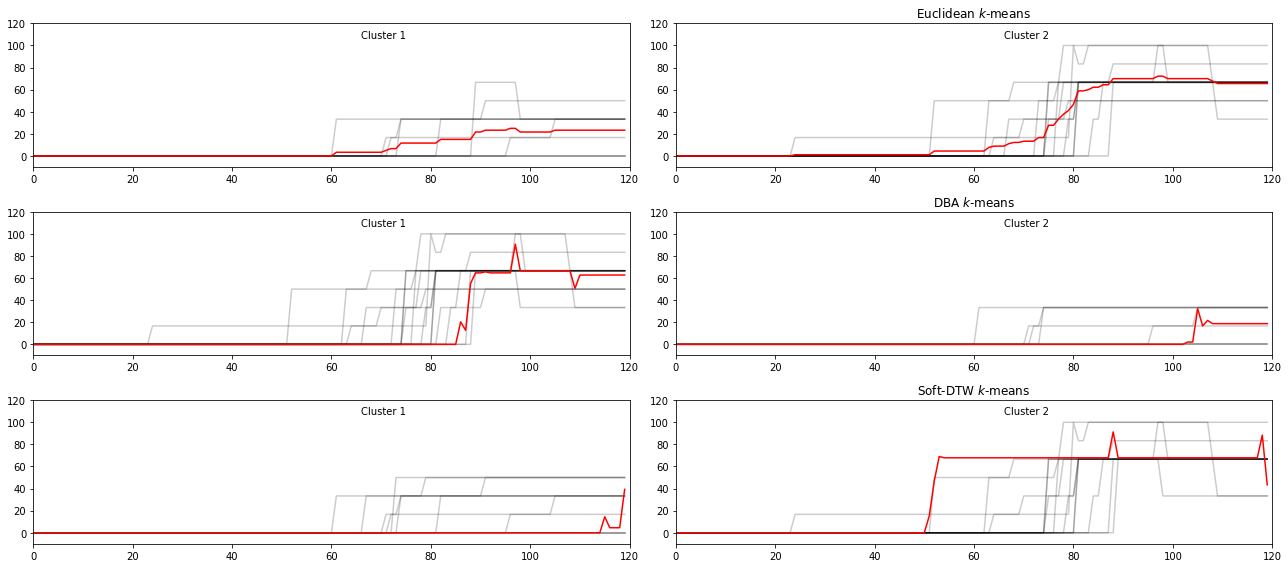

Euclidean k-means
The cluster 1 is composed by the features:
C6_CAN,C6_DEN,C6_AUS,C6_JAP,C6_FIN,C6_ICE,C6_NOR,C6_BRA'
 'C6_POL,C6_SWE
The cluster 2 is composed by the features:
C6_FRA,C6_GER,C6_NET,C6_UK,C6_ITA,C6_ISR,C6_LUX,C6_POR'
 'C6_CRO,C6_IRE,C6_NEW,C6_MEX,C6_UNI,C6_IND,C6_RUS
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C6_FRA,C6_GER,C6_NET,C6_UK,C6_ITA,C6_ISR,C6_AUS,C6_LUX'
 'C6_POR,C6_CRO,C6_IRE,C6_NEW,C6_MEX,C6_UNI,C6_IND,C6_RUS'
 'C6_POL
The cluster 2 is composed by the features:
C6_CAN,C6_DEN,C6_JAP,C6_FIN,C6_ICE,C6_NOR,C6_BRA,C6_SWE
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C6_CAN,C6_DEN,C6_GER,C6_AUS,C6_JAP,C6_FIN,C6_ICE,C6_NOR'
 'C6_BRA,C6_UNI,C6_SWE
The cluster 2 is composed by the features:
C6_FRA,C6_NET,C6_UK,C6_ITA,C6_ISR,C6_LUX,C6_POR,C6_CRO'
 'C6_IRE,C6_NEW,C6_MEX,C6_IND,C6_RUS,C6_POL


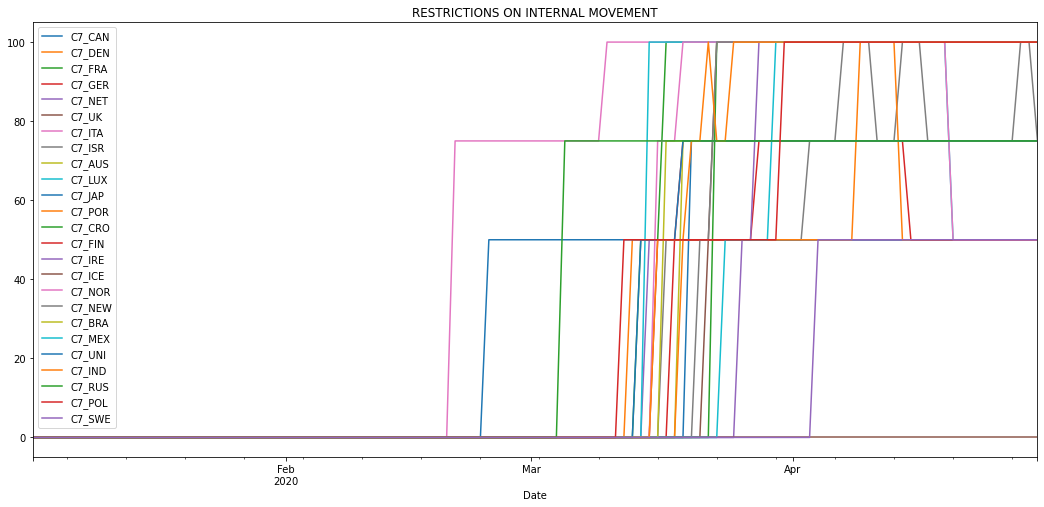

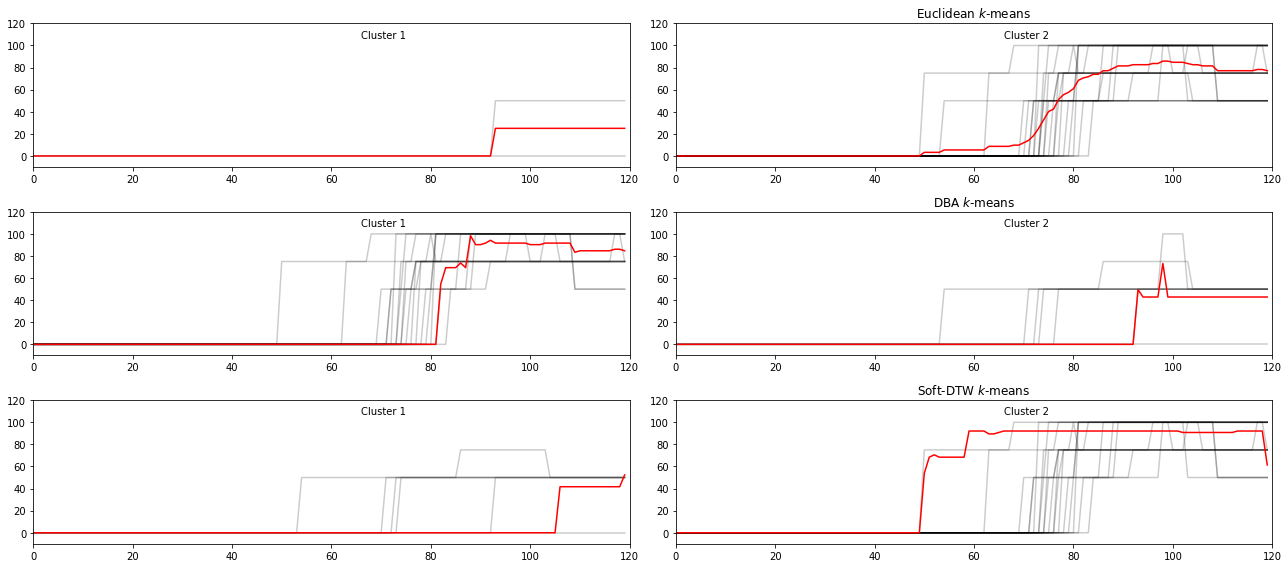

Euclidean k-means
The cluster 1 is composed by the features:
C7_ICE,C7_SWE
The cluster 2 is composed by the features:
C7_CAN,C7_DEN,C7_FRA,C7_GER,C7_NET,C7_UK,C7_ITA,C7_ISR'
 'C7_AUS,C7_LUX,C7_JAP,C7_POR,C7_CRO,C7_FIN,C7_IRE,C7_NOR'
 'C7_NEW,C7_BRA,C7_MEX,C7_UNI,C7_IND,C7_RUS,C7_POL
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C7_CAN,C7_FRA,C7_GER,C7_UK,C7_ITA,C7_ISR,C7_AUS,C7_LUX'
 'C7_CRO,C7_IRE,C7_NOR,C7_NEW,C7_BRA,C7_MEX,C7_UNI,C7_IND'
 'C7_RUS,C7_POL
The cluster 2 is composed by the features:
C7_DEN,C7_NET,C7_JAP,C7_POR,C7_FIN,C7_ICE,C7_SWE
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C7_DEN,C7_NET,C7_JAP,C7_FIN,C7_ICE,C7_SWE
The cluster 2 is composed by the features:
C7_CAN,C7_FRA,C7_GER,C7_UK,C7_ITA,C7_ISR,C7_AUS,C7_LUX'
 'C7_POR,C7_CRO,C7_IRE,C7_NOR,C7_NEW,C7_BRA,C7_MEX,C7_UNI'
 'C7_IND,C7_RUS,C7_POL


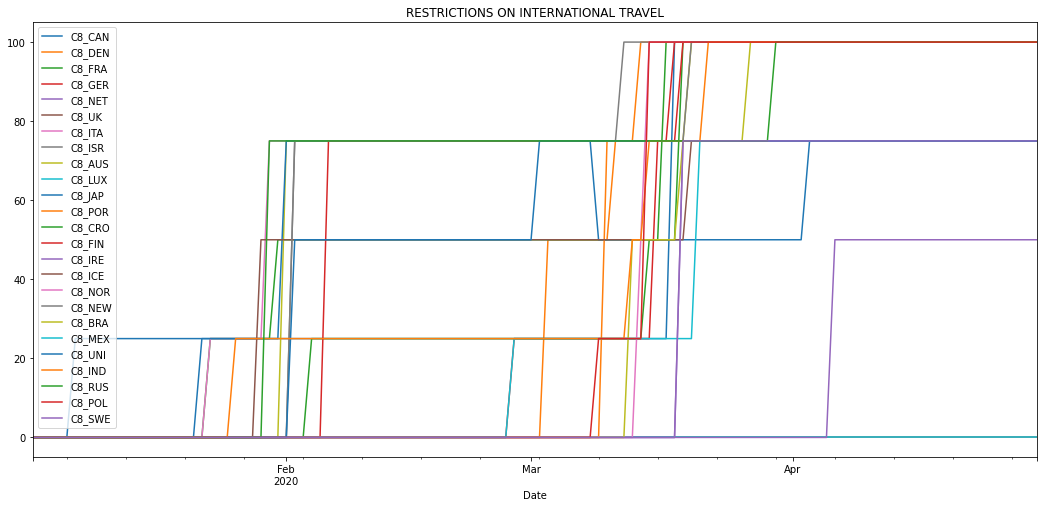

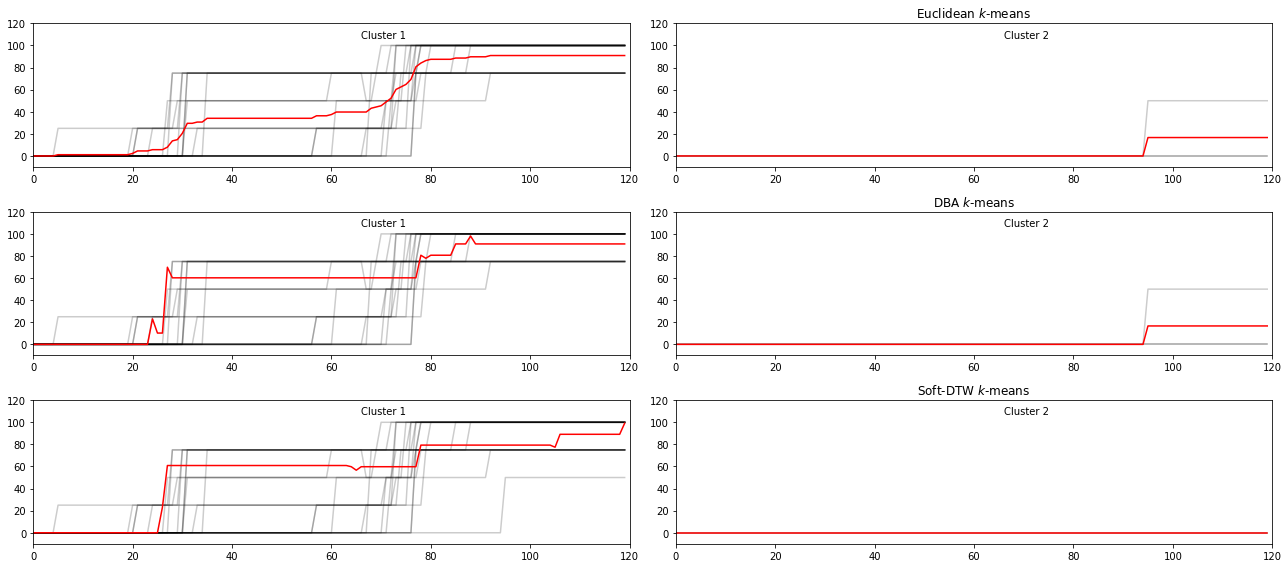

Euclidean k-means
The cluster 1 is composed by the features:
C8_CAN,C8_DEN,C8_FRA,C8_GER,C8_NET,C8_ITA,C8_ISR,C8_AUS'
 'C8_JAP,C8_POR,C8_CRO,C8_FIN,C8_ICE,C8_NOR,C8_NEW,C8_BRA'
 'C8_MEX,C8_UNI,C8_IND,C8_RUS,C8_POL,C8_SWE
The cluster 2 is composed by the features:
C8_UK,C8_LUX,C8_IRE
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
C8_CAN,C8_DEN,C8_FRA,C8_GER,C8_NET,C8_ITA,C8_ISR,C8_AUS'
 'C8_JAP,C8_POR,C8_CRO,C8_FIN,C8_ICE,C8_NOR,C8_NEW,C8_BRA'
 'C8_MEX,C8_UNI,C8_IND,C8_RUS,C8_POL,C8_SWE
The cluster 2 is composed by the features:
C8_UK,C8_LUX,C8_IRE
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
C8_CAN,C8_DEN,C8_FRA,C8_GER,C8_NET,C8_ITA,C8_ISR,C8_AUS'
 'C8_JAP,C8_POR,C8_CRO,C8_FIN,C8_IRE,C8_ICE,C8_NOR,C8_NEW'
 'C8_BRA,C8_MEX,C8_UNI,C8_IND,C8_RUS,C8_POL,C8_SWE
The cluster 2 is composed by the features:
C8_UK,C8_LUX


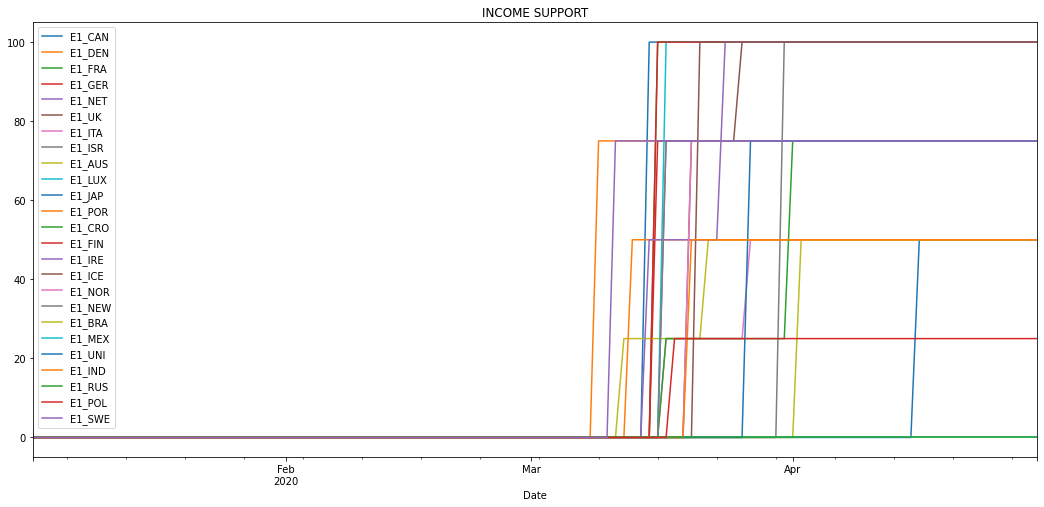

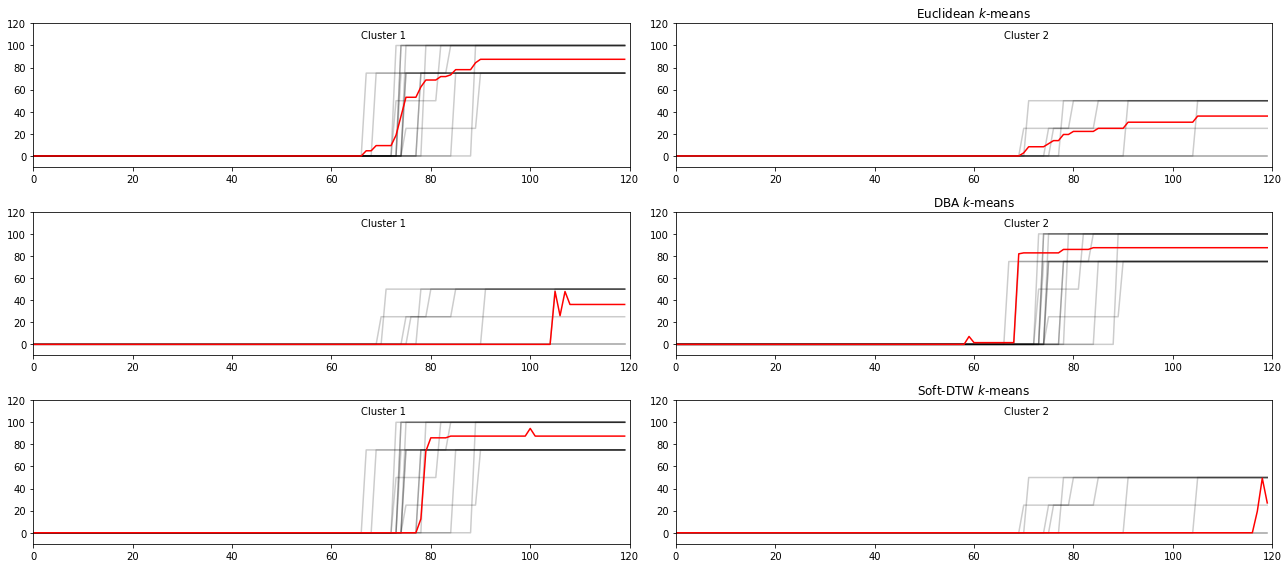

Euclidean k-means
The cluster 1 is composed by the features:
E1_CAN,E1_DEN,E1_FRA,E1_GER,E1_NET,E1_UK,E1_ISR,E1_LUX'
 'E1_CRO,E1_FIN,E1_IRE,E1_ICE,E1_NOR,E1_NEW,E1_UNI,E1_SWE
The cluster 2 is composed by the features:
E1_ITA,E1_AUS,E1_JAP,E1_POR,E1_BRA,E1_MEX,E1_IND,E1_RUS'
 'E1_POL
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
E1_ITA,E1_AUS,E1_JAP,E1_POR,E1_BRA,E1_MEX,E1_IND,E1_RUS'
 'E1_POL
The cluster 2 is composed by the features:
E1_CAN,E1_DEN,E1_FRA,E1_GER,E1_NET,E1_UK,E1_ISR,E1_LUX'
 'E1_CRO,E1_FIN,E1_IRE,E1_ICE,E1_NOR,E1_NEW,E1_UNI,E1_SWE
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
E1_CAN,E1_DEN,E1_FRA,E1_GER,E1_NET,E1_UK,E1_ISR,E1_LUX'
 'E1_CRO,E1_FIN,E1_IRE,E1_ICE,E1_NOR,E1_NEW,E1_UNI,E1_SWE
The cluster 2 is composed by the features:
E1_ITA,E1_AUS,E1_JAP,E1_POR,E1_BRA,E1_MEX,E1_IND,E1_RUS'
 'E1_POL


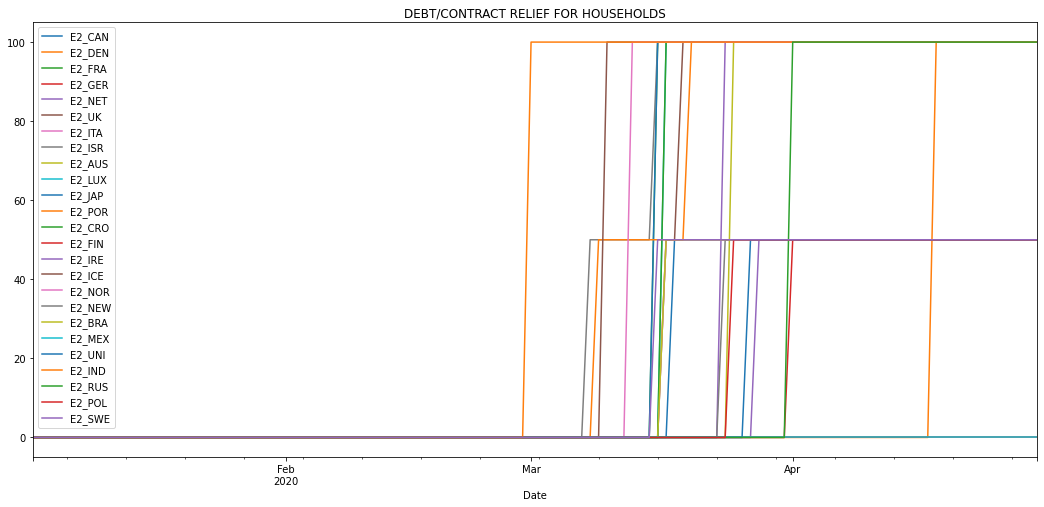

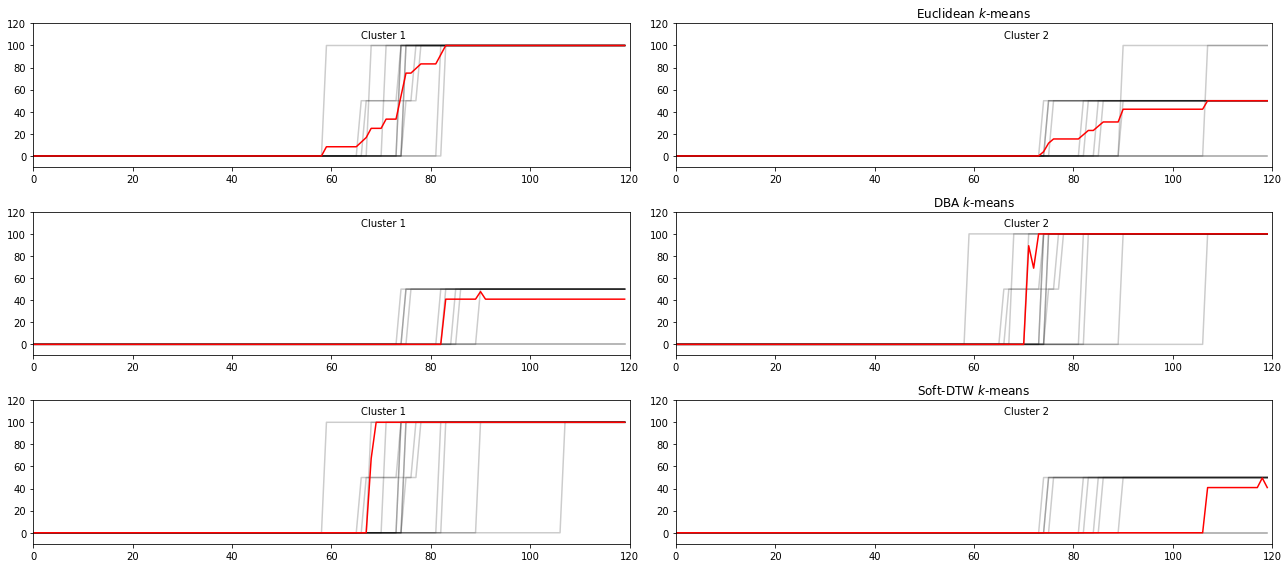

Euclidean k-means
The cluster 1 is composed by the features:
E2_FRA,E2_UK,E2_ISR,E2_AUS,E2_LUX,E2_JAP,E2_POR,E2_CRO'
 'E2_IRE,E2_ICE,E2_NOR,E2_IND
The cluster 2 is composed by the features:
E2_CAN,E2_DEN,E2_GER,E2_NET,E2_ITA,E2_FIN,E2_NEW,E2_BRA'
 'E2_MEX,E2_UNI,E2_RUS,E2_POL,E2_SWE
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
E2_CAN,E2_GER,E2_NET,E2_ITA,E2_FIN,E2_NEW,E2_BRA,E2_MEX'
 'E2_UNI,E2_POL,E2_SWE
The cluster 2 is composed by the features:
E2_DEN,E2_FRA,E2_UK,E2_ISR,E2_AUS,E2_LUX,E2_JAP,E2_POR'
 'E2_CRO,E2_IRE,E2_ICE,E2_NOR,E2_IND,E2_RUS
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
E2_DEN,E2_FRA,E2_UK,E2_ISR,E2_AUS,E2_LUX,E2_JAP,E2_POR'
 'E2_CRO,E2_IRE,E2_ICE,E2_NOR,E2_IND,E2_RUS
The cluster 2 is composed by the features:
E2_CAN,E2_GER,E2_NET,E2_ITA,E2_FIN,E2_NEW,E2_BRA,E2_MEX'
 'E2_UNI,E2_POL,E2_SWE


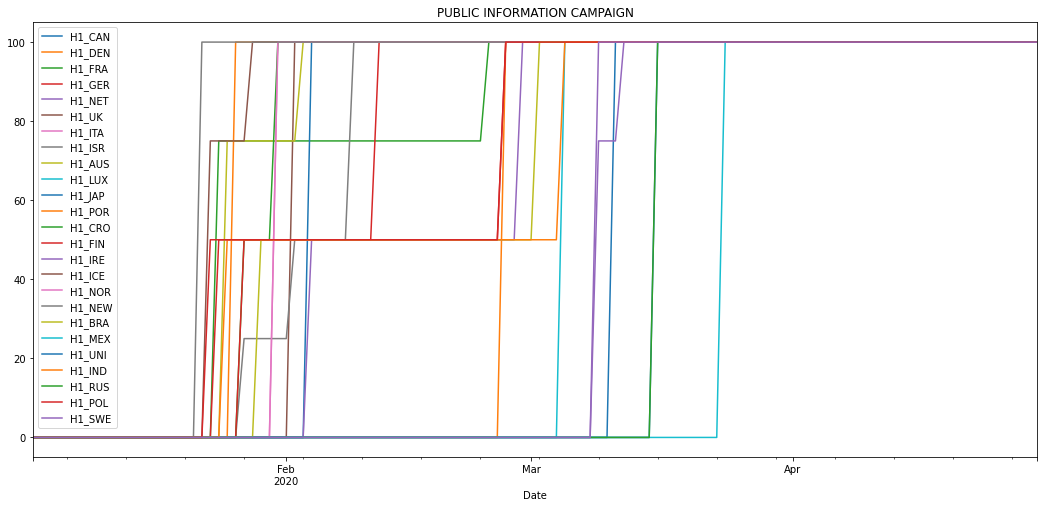

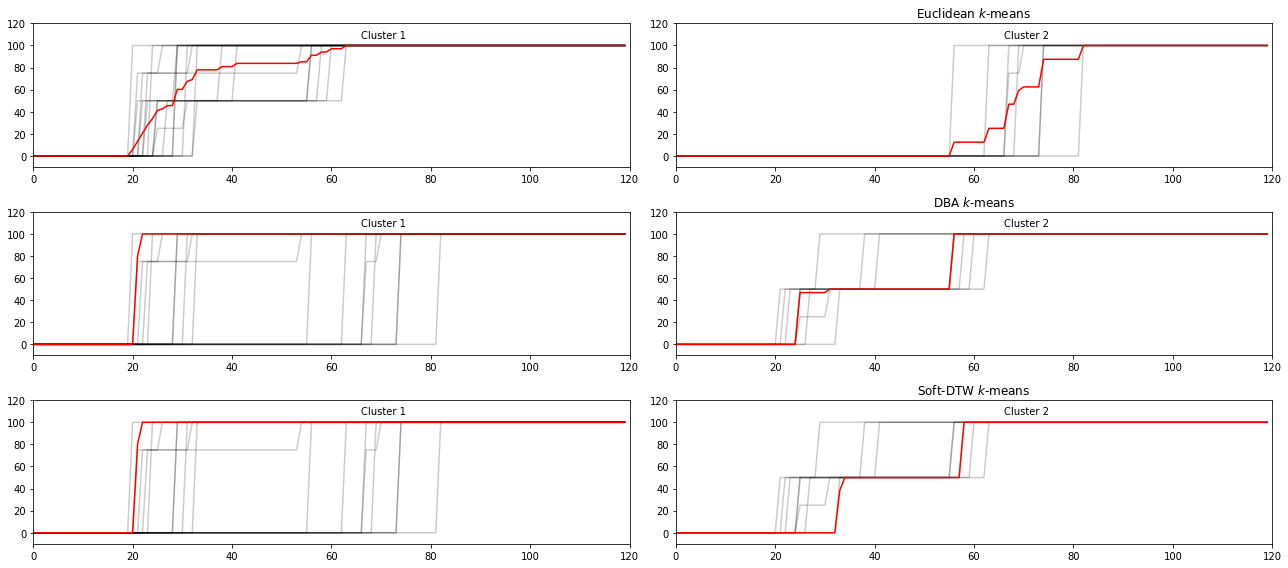

Euclidean k-means
The cluster 1 is composed by the features:
H1_FRA,H1_GER,H1_UK,H1_ITA,H1_ISR,H1_AUS,H1_JAP,H1_POR'
 'H1_CRO,H1_FIN,H1_IRE,H1_ICE,H1_NOR,H1_NEW,H1_BRA,H1_IND'
 'H1_POL
The cluster 2 is composed by the features:
H1_CAN,H1_DEN,H1_NET,H1_LUX,H1_MEX,H1_UNI,H1_RUS,H1_SWE
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
H1_CAN,H1_DEN,H1_FRA,H1_NET,H1_UK,H1_ITA,H1_AUS,H1_LUX'
 'H1_JAP,H1_POR,H1_ICE,H1_NOR,H1_NEW,H1_MEX,H1_UNI,H1_RUS'
 'H1_SWE
The cluster 2 is composed by the features:
H1_GER,H1_ISR,H1_CRO,H1_FIN,H1_IRE,H1_BRA,H1_IND,H1_POL
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
H1_CAN,H1_DEN,H1_FRA,H1_NET,H1_UK,H1_ITA,H1_AUS,H1_LUX'
 'H1_JAP,H1_POR,H1_ICE,H1_NOR,H1_NEW,H1_MEX,H1_UNI,H1_RUS'
 'H1_SWE
The cluster 2 is composed by the features:
H1_GER,H1_ISR,H1_CRO,H1_FIN,H1_IRE,H1_BRA,H1_IND,H1_POL


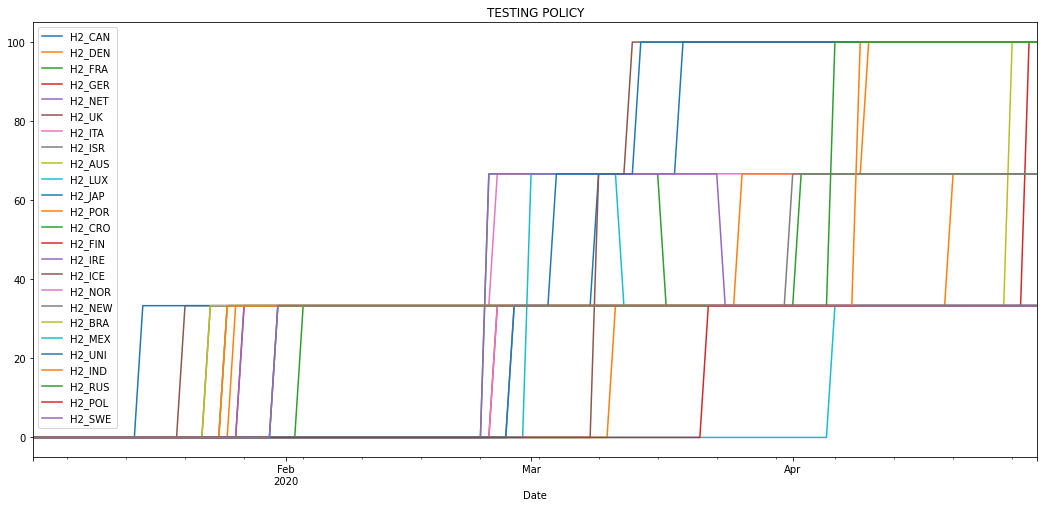

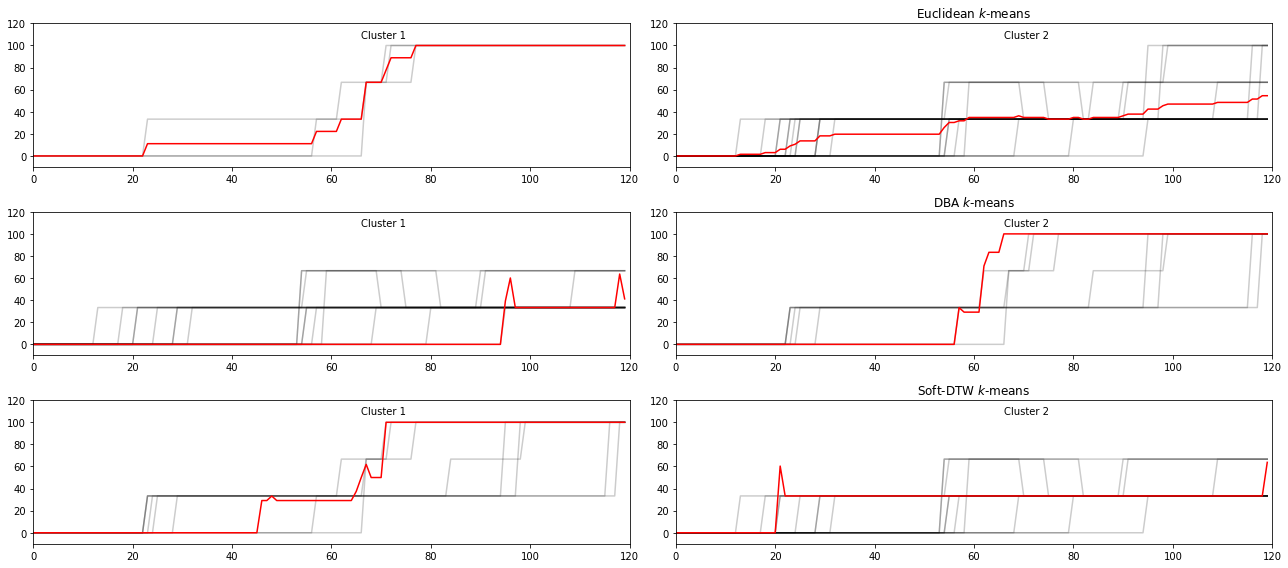

Euclidean k-means
The cluster 1 is composed by the features:
H2_CAN,H2_ICE,H2_UNI
The cluster 2 is composed by the features:
H2_DEN,H2_FRA,H2_GER,H2_NET,H2_UK,H2_ITA,H2_ISR,H2_AUS'
 'H2_LUX,H2_JAP,H2_POR,H2_CRO,H2_FIN,H2_IRE,H2_NOR,H2_NEW'
 'H2_BRA,H2_MEX,H2_IND,H2_RUS,H2_POL,H2_SWE
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
H2_DEN,H2_FRA,H2_NET,H2_UK,H2_ITA,H2_ISR,H2_LUX,H2_JAP'
 'H2_CRO,H2_FIN,H2_IRE,H2_NOR,H2_NEW,H2_BRA,H2_MEX,H2_POL'
 'H2_SWE
The cluster 2 is composed by the features:
H2_CAN,H2_GER,H2_AUS,H2_POR,H2_ICE,H2_UNI,H2_IND,H2_RUS
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
H2_CAN,H2_GER,H2_AUS,H2_POR,H2_ICE,H2_UNI,H2_IND,H2_RUS
The cluster 2 is composed by the features:
H2_DEN,H2_FRA,H2_NET,H2_UK,H2_ITA,H2_ISR,H2_LUX,H2_JAP'
 'H2_CRO,H2_FIN,H2_IRE,H2_NOR,H2_NEW,H2_BRA,H2_MEX,H2_POL'
 'H2_SWE


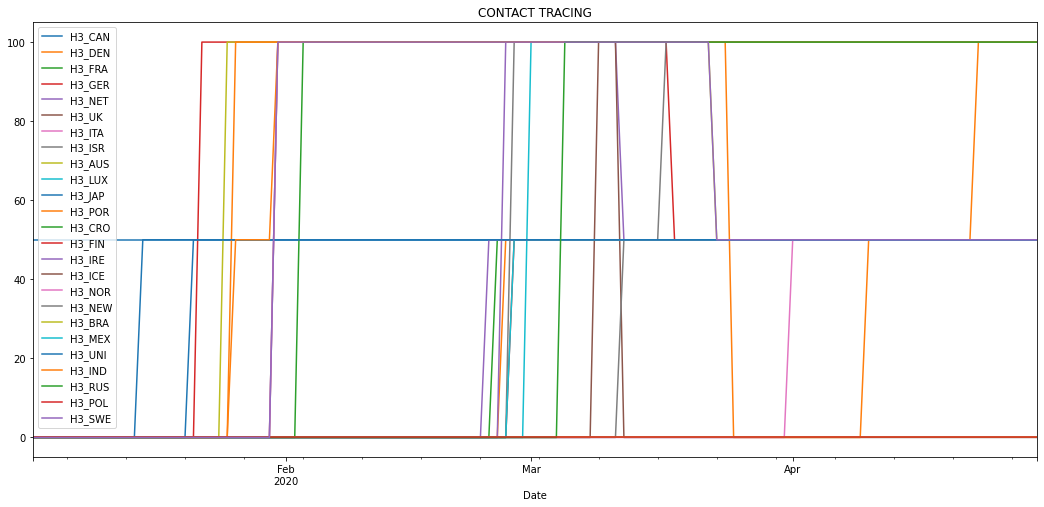

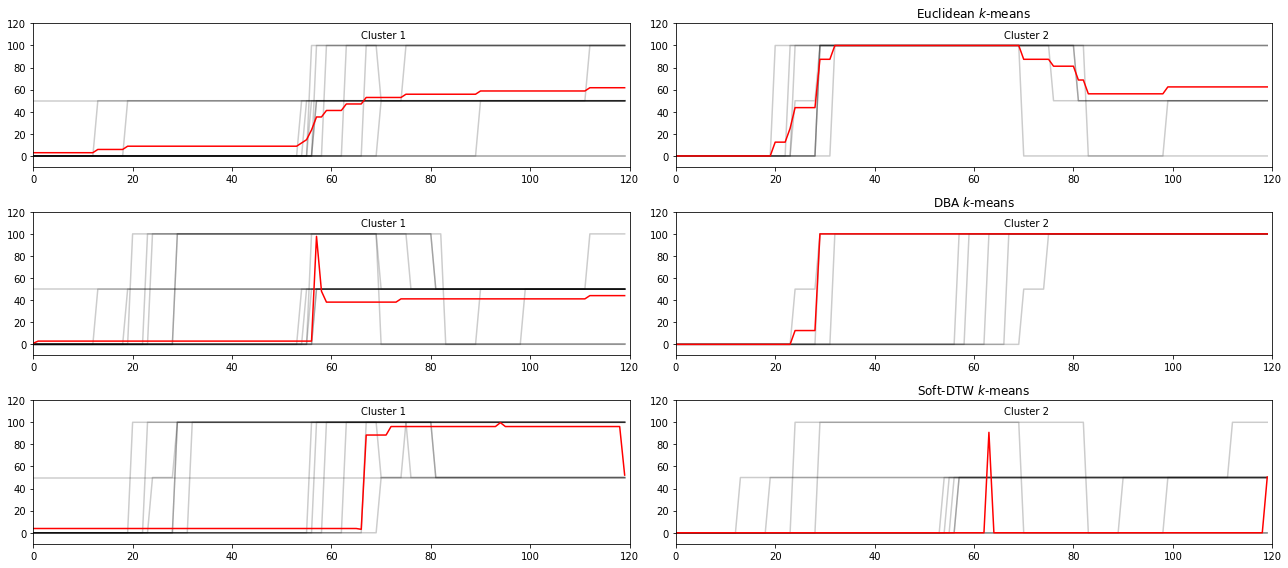

Euclidean k-means
The cluster 1 is composed by the features:
H3_CAN,H3_DEN,H3_FRA,H3_NET,H3_ISR,H3_LUX,H3_JAP,H3_FIN'
 'H3_IRE,H3_ICE,H3_NOR,H3_NEW,H3_BRA,H3_MEX,H3_UNI,H3_RUS'
 'H3_POL
The cluster 2 is composed by the features:
H3_GER,H3_UK,H3_ITA,H3_AUS,H3_POR,H3_CRO,H3_IND,H3_SWE
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
H3_CAN,H3_DEN,H3_FRA,H3_GER,H3_NET,H3_UK,H3_AUS,H3_JAP'
 'H3_POR,H3_FIN,H3_IRE,H3_NOR,H3_BRA,H3_MEX,H3_UNI,H3_POL'
 'H3_SWE
The cluster 2 is composed by the features:
H3_ITA,H3_ISR,H3_LUX,H3_CRO,H3_ICE,H3_NEW,H3_IND,H3_RUS
********************************************
Soft-Dynamic Time Warping
The cluster 1 is composed by the features:
H3_CAN,H3_GER,H3_NET,H3_ITA,H3_ISR,H3_AUS,H3_LUX,H3_CRO'
 'H3_ICE,H3_NEW,H3_IND,H3_RUS,H3_SWE
The cluster 2 is composed by the features:
H3_DEN,H3_FRA,H3_UK,H3_JAP,H3_POR,H3_FIN,H3_IRE,H3_NOR'
 'H3_BRA,H3_MEX,H3_UNI,H3_POL


In [13]:
cont=0
for x in features:
  nanai=full_set[[col for col in full_set if col.startswith(str(x)[:2])]]

  X_train=nanai.values
  X_train=X_train.T
  sz = X_train.shape[1]

  nanai.plot.line(figsize=(18,8), legend=True , title=titles[cont].upper())
  cont += 1
  clusters=2

  # Euclidean k-means
  km = TimeSeriesKMeans(n_clusters=clusters, verbose=False, random_state=seed, n_jobs=-1)
  y_pred_0 = km.fit_predict(X_train)

  plt.figure(figsize=(18,8))
  for yi in range(clusters):
      plt.subplot(3, clusters, yi + 1)
      for xx in X_train[y_pred_0 == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
      plt.plot(km.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(-10, 120)
      plt.text(0.55, 0.9,'Cluster %d' % (yi + 1),
              transform=plt.gca().transAxes)
      if yi == 1:
          plt.title("Euclidean $k$-means")

  # DBA-k-means
  dba_km = TimeSeriesKMeans(n_clusters=clusters, n_init=2, metric="dtw",  verbose=False, max_iter_barycenter=10, random_state=seed)
  y_pred_1 = dba_km.fit_predict(X_train)

  for yi in range(clusters):
      plt.subplot(3, clusters, ((clusters*1)+1) + yi)
      for xx in X_train[y_pred_1 == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
      plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(-10, 120)
      plt.text(0.55, 0.9,'Cluster %d' % (yi + 1),
              transform=plt.gca().transAxes)
      if yi == 1:
          plt.title("DBA $k$-means")

  # Soft-DTW-k-meansy
  sdtw_km = TimeSeriesKMeans(n_clusters=clusters,  metric="softdtw", metric_params={"gamma": .01},  verbose=False, random_state=seed)
  y_pred_2 = sdtw_km.fit_predict(X_train)

  for yi in range(clusters):
      plt.subplot(3, clusters, ((clusters*2)+1) + yi)
      for xx in X_train[y_pred_2 == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
      plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(-10, 120)
      plt.text(0.55, 0.90,'Cluster %d' % (yi + 1),
              transform=plt.gca().transAxes)
      if yi == 1:
          plt.title("Soft-DTW $k$-means")

  plt.tight_layout()
  plt.show()
  # plt.savefig(path+"/plot")
  plt.clf()
  plt.close()

  # file1.write("Euclidean k-means\n")
  print("Euclidean k-means")
  for x in range(clusters):
    print("The cluster %i is composed by the features:" % (x+1))
    # file1.write("The cluster %i is composed by the features:\n" % (x+1))
    print(str(nanai.columns.where(y_pred_0 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))
    # file1.write(str(nanai.columns.where(y_pred_0 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", "")+"\n")
  print("********************************************")
  # file1.write("\nDBA k-means\n")
  print("Dynamic Time Warping Barycenter Averaging")
  for x in range(clusters):
    print("The cluster %i is composed by the features:" % (x+1))
    # file1.write("The cluster %i is composed by the features:\n" % (x+1))
    print(str(nanai.columns.where(y_pred_1 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))
    # file1.write(str(nanai.columns.where(y_pred_1 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", "")+"\n")
  print("********************************************")
  # file1.write("\nSoft-DTW k-means\n")
  print("Soft-Dynamic Time Warping")
  for x in range(clusters):
    print("The cluster %i is composed by the features:" % (x+1))
    # file1.write("The cluster %i is composed by the features:\n" % (x+1))
    print(str(nanai.columns.where(y_pred_2 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))
    # file1.write(str(nanai.columns.where(y_pred_2 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))

#barycenter in red

# CLUSTERING BY DEATH TOLLS

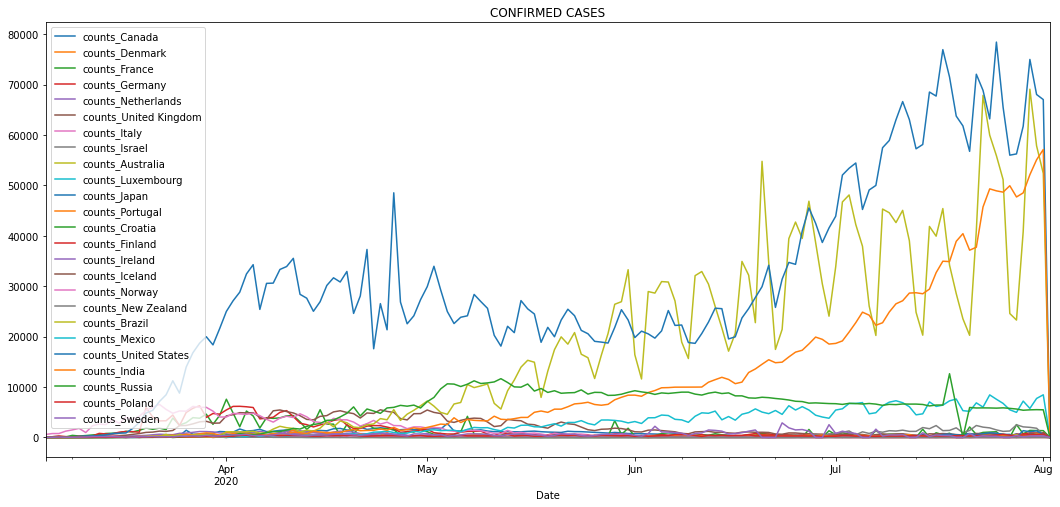

In [14]:
#'ConfirmedCases','ConfirmedDeaths'
variable='ConfirmedCases'

def tag():
  if i == "United Kingdom":
    return "UK"
  else:
    return i[:3].upper()

# fecha=datetime.today().strftime('%Y%m%d')
# total_start_time = time.time()

# path=("/home/org00004/LSTM/plots/"+fecha+"_knn_deaths")
# Path(path).mkdir(parents=True, exist_ok=True)

#SEED
seed = 7
numpy.random.seed(7)
tf.random.set_seed(123)

#LOADING DATASET
dataset_global = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')
dataset_global["Date"]= pd.to_datetime(dataset_global["Date"], format='%Y%m%d')

# file1 = open(path+"/"+"log.txt","w")

full_set = pd.DataFrame()
for i in country:
	dataset=dataset_global.loc[( (dataset_global.CountryName ==i) & (dataset_global.Date > "2020-03-01")),['CountryName','CountryCode','Date','C1_School closing','C1_Flag','C2_Workplace closing','C2_Flag','C3_Cancel public events','C3_Flag','C4_Restrictions on gatherings','C4_Flag','C5_Close public transport','C5_Flag','C6_Stay at home requirements','C6_Flag','C7_Restrictions on internal movement','C7_Flag','C8_International travel controls','E1_Income support','E1_Flag','E2_Debt/contract relief','E3_Fiscal measures','E4_International support','H1_Public information campaigns','H1_Flag','H2_Testing policy','H3_Contact tracing','H4_Emergency investment in healthcare','H5_Investment in vaccines','M1_Wildcard','ConfirmedCases','ConfirmedDeaths']].set_index('Date')
	dataset.columns = ['CountryName','CountryCode','C1','C1_Flag','C2','C2_Flag','C3','C3_Flag','C4','C4_Flag','C5','C5_Flag','C6','C6_Flag','C7','C7_Flag','C8','E1','E1_Flag','E2','E3','E4','H1','H1_Flag','H2','H3','H4','H5','M1','ConfirmedCases','ConfirmedDeaths']
	
	#filling NaN due to uplead delay (Because data are updated on twice-weekly cycles, but not every country is updated in every cycle)
	dataset.fillna(method='ffill', inplace=True)

	#columns to look for missing values.
	dataset.dropna(subset=[variable])

	#creating death toll per day
	dataset['counts']=dataset[variable].diff()
	dataset=dataset.drop(columns=[variable])
	
	dataset=dataset[['counts']]
	dataset.loc[(dataset['counts'] < 0), 'counts'] = 0
	dataset=dataset.dropna()
	
	indexes_covid=dataset[['counts']]
	indexes_covid.columns = ['counts_'+i]
	
	full_set= pd.concat([full_set, indexes_covid], axis=1).dropna()
	
X_train=full_set.values
X_train=X_train.T
sz = X_train.shape[1]

full_set.plot.line(figsize=(18,8) , title='CONFIRMED CASES')


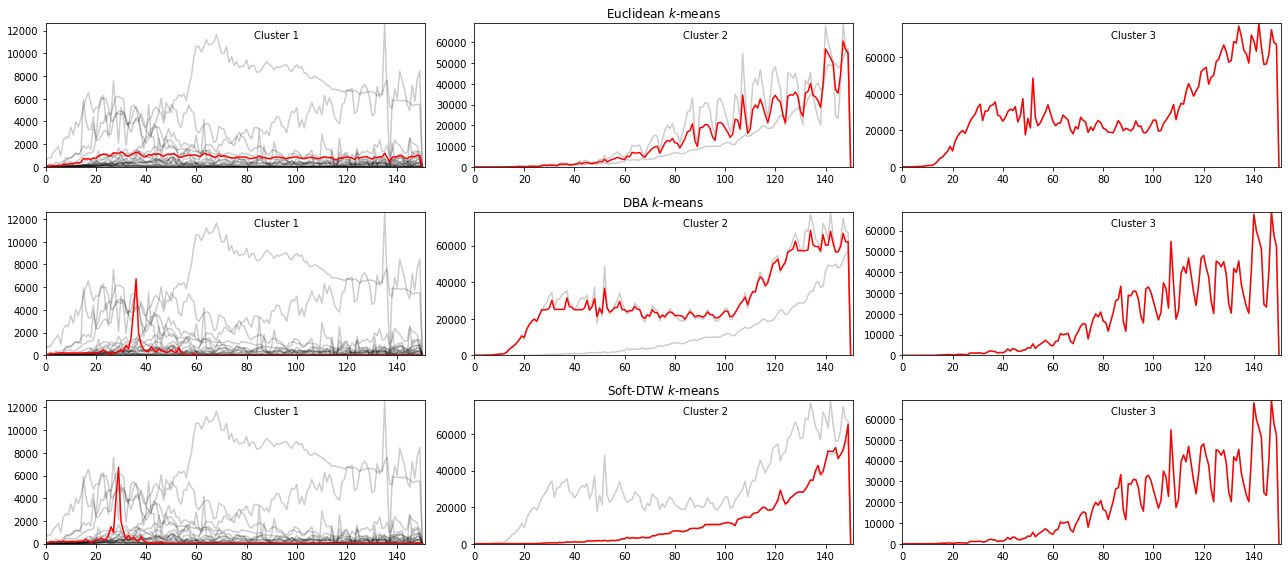

Euclidean k-means
The cluster 1 is composed by the features:
Index(['counts_Canada', 'counts_Denmark', 'counts_France', 'counts_Germany',
       'counts_Netherlands', 'counts_United Kingdom', 'counts_Italy',
       'counts_Israel', 'counts_Australia', 'counts_Luxembourg',
       'counts_Japan', 'counts_Portugal', 'counts_Croatia', 'counts_Finland',
       'counts_Ireland', 'counts_Iceland', 'counts_Norway',
       'counts_New Zealand', 'counts_Mexico', 'counts_Russia', 'counts_Poland',
       'counts_Sweden'],
      dtype='object')
The cluster 2 is composed by the features:
Index(['counts_Brazil', 'counts_India'], dtype='object')
The cluster 3 is composed by the features:
Index(['counts_United States'], dtype='object')
********************************************
Dynamic Time Warping Barycenter Averaging
The cluster 1 is composed by the features:
Index(['counts_Canada', 'counts_Denmark', 'counts_France', 'counts_Germany',
       'counts_Netherlands', 'counts_United Kingdom', 'counts_It

In [15]:
clusters=3

# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=clusters, verbose=False, random_state=seed, n_jobs=-1)
y_pred_0 = km.fit_predict(X_train)


plt.figure(figsize=(18,8))
for yi in range(clusters):
	plt.subplot(3, clusters, yi + 1)
	max_val=X_train[y_pred_0 == yi].max()
	for xx in X_train[y_pred_0 == yi]:
		plt.plot(xx.ravel(), "k-", alpha=.2)
	plt.plot(km.cluster_centers_[yi].ravel(), "r-")
	plt.xlim(0, sz)
	plt.ylim(-10, max_val)
	plt.text(0.55, 0.9,'Cluster %d' % (yi + 1),transform=plt.gca().transAxes)
	if yi == 1:
		plt.title("Euclidean $k$-means")

# DBA-k-means
dba_km = TimeSeriesKMeans(n_clusters=clusters, n_init=2, metric="dtw",  verbose=False, max_iter_barycenter=10, random_state=seed)
y_pred_1 = dba_km.fit_predict(X_train)


for yi in range(clusters):
	plt.subplot(3, clusters, ((clusters*1)+1) + yi)
	max_val=X_train[y_pred_1 == yi].max()
	for xx in X_train[y_pred_1 == yi]:
		plt.plot(xx.ravel(), "k-", alpha=.2)
	plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
	plt.xlim(0, sz)
	plt.ylim(-10, max_val)
	plt.text(0.55, 0.9,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
	if yi == 1:
		plt.title("DBA $k$-means")

# Soft-DTW-k-meansy
sdtw_km = TimeSeriesKMeans(n_clusters=clusters,  metric="softdtw", metric_params={"gamma": .01},  verbose=False, random_state=seed)
y_pred_2 = sdtw_km.fit_predict(X_train)


for yi in range(clusters):
	plt.subplot(3, clusters, ((clusters*2)+1) + yi)
	max_val=X_train[y_pred_2 == yi].max()
	for xx in X_train[y_pred_2 == yi]:
		plt.plot(xx.ravel(), "k-", alpha=.2)
	plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
	plt.xlim(0, sz)
	plt.ylim(-10, max_val)
	plt.text(0.55, 0.90,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
	if yi == 1:
		plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()
# plt.savefig(path+"/plot")
plt.clf()
plt.close()

# file1.write("Euclidean k-means\n")
print("Euclidean k-means")
for x in range(clusters):
  print("The cluster %i is composed by the features:" % (x+1))
  # file1.write("The cluster %i is composed by the features:\n" % (x+1))
  print(full_set.columns.where(y_pred_0 == x).dropna())
  # file1.write(str(full_set.columns.where(y_pred_0 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", "")+"\n")
print("********************************************")
# file1.write("\nDBA k-means\n")
print("Dynamic Time Warping Barycenter Averaging")
for x in range(clusters):
  print("The cluster %i is composed by the features:" % (x+1))
  # file1.write("The cluster %i is composed by the features:\n" % (x+1))
  print(full_set.columns.where(y_pred_1 == x).dropna())
  # file1.write(str(full_set.columns.where(y_pred_1 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", "")+"\n")
print("********************************************")
# file1.write("\nSoft-DTW k-means\n")
print("Soft-Dynamic Time Warping")
for x in range(clusters):
  print("The cluster %i is composed by the features:" % (x+1))
  # file1.write("The cluster %i is composed by the features:\n" % (x+1))
  print(full_set.columns.where(y_pred_2 == x).dropna())
  # file1.write(str(full_set.columns.where(y_pred_2 == x).dropna().values).replace("['", "").replace("' '", ",").replace("']", ""))

# file1.close()